In [1]:
import copy
from pathlib import Path
import warnings
import random

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
model_paths = ["Save_File/seperate_model_holi_wkend_05_31/A.ckpt",
                "Save_File/seperate_model_holi_wkend_05_31/B.ckpt",
                "Save_File/seperate_model_holi_wkend_05_31/C.ckpt",
                "Save_File/seperate_model_holi_wkend_05_31/D.ckpt",
                "Save_File/seperate_model_holi_wkend_05_31/E.ckpt"]

# model_paths = ["Save_File/seperate_model_6hour_05_31/A.ckpt",
#                 "Save_File/seperate_model_6hour_05_31/B.ckpt",
#                 "Save_File/seperate_model_6hour_05_31/C.ckpt",
#                 "Save_File/seperate_model_6hour_05_31/D.ckpt",
#                 "Save_File/seperate_model_6hour_05_31/E.ckpt"]

# model_paths = ["Save_File/seperate_model_24hour_05_31/A.ckpt",
#                 "Save_File/seperate_model_24hour_05_31/B.ckpt",
#                 "Save_File/seperate_model_24hour_05_31/C.ckpt",
#                 "Save_File/seperate_model_24hour_05_31/D.ckpt",
#                 "Save_File/seperate_model_24hour_05_31/E.ckpt"]

# model_paths = ["Save_File/seperate_model_best_05_28/A/checkpoints/epoch=39-step=1199.ckpt",
#                 "Save_File/seperate_model_best_05_28/B/checkpoints/epoch=57-step=1739.ckpt",
#                 "Save_File/seperate_model_best_05_28/C/checkpoints/epoch=41-step=1259.ckpt",
#                 "Save_File/seperate_model_best_05_28/D/checkpoints/epoch=44-step=1349.ckpt",
#                 "Save_File/seperate_model_best_05_28/E/checkpoints/epoch=40-step=1229.ckpt"]

input_length = 168
output_length = 24

show_graph = False

dataframes = []

group_name = ["A", "B", "C", "D", "E"]

for i in range(len(group_name)):
    dataset = pd.read_csv(f"Refined_Data/Grouped_Data/{group_name[i]}.csv", index_col=0)
    dataframes.append(dataset)

In [3]:
group = [
    [34, 40, 42, 41, 4, 10, 11, 12],
    [35, 6, 48, 27, 57, 8, 25, 56, 26, 55, 47, 13, 53, 18, 7, 17, 46],
    [31, 33, 9, 3, 1, 32],
    [29, 38, 43, 58, 15, 22, 39, 54, 23, 44, 45, 37, 52, 2, 14],
    [21, 19, 50, 49, 20, 51, 30, 36, 28, 59, 5, 60, 16, 24]
]

random_choice = 6 # random.randrange(2,13)

start_point = -168 * random_choice - 1
duration = 168

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

all_smape = []
part_smape = [[],[],[],[],[]]

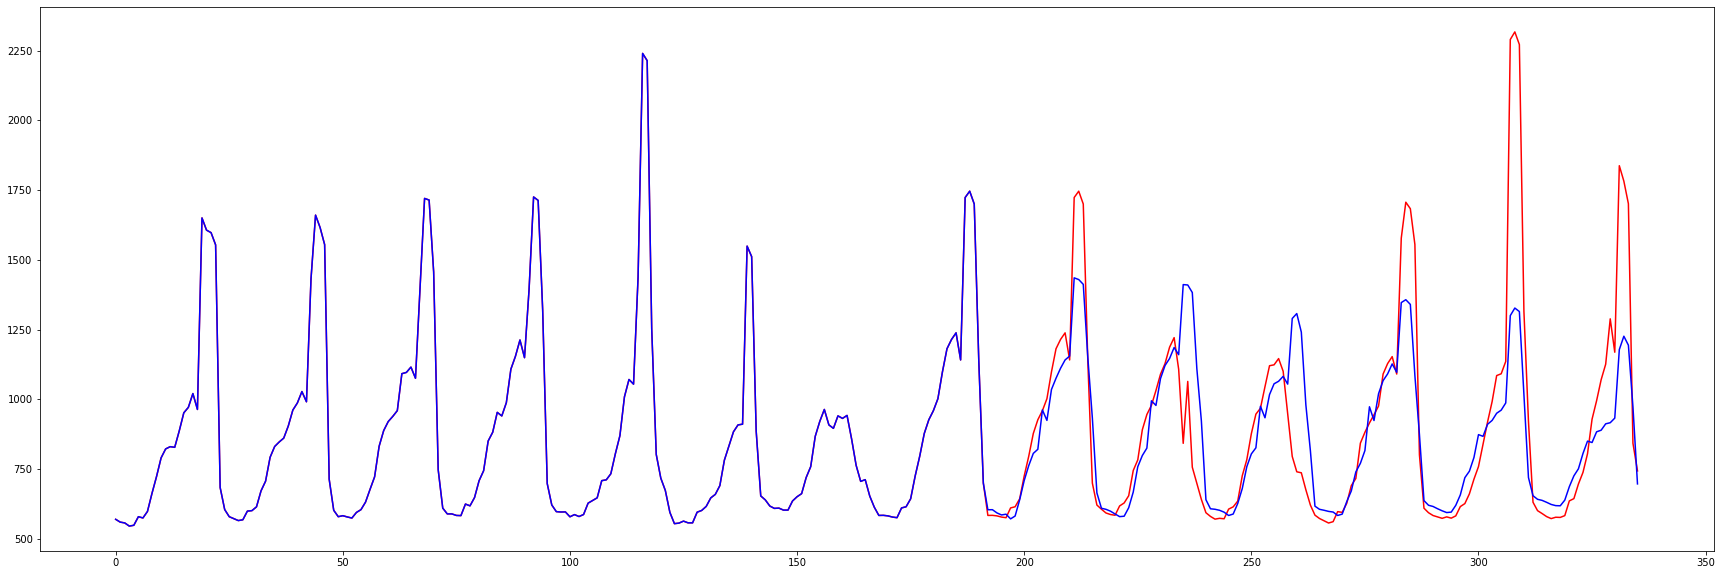

10.236748873322922


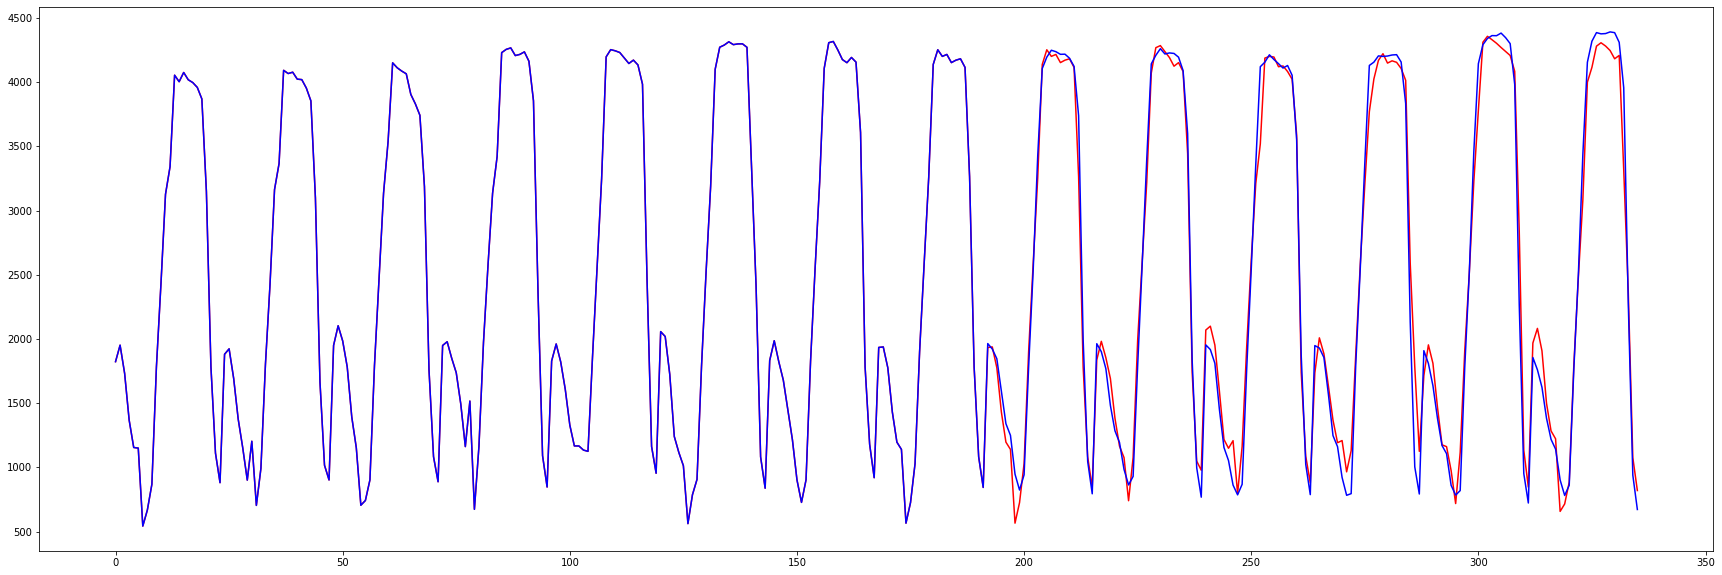

6.647819754223649


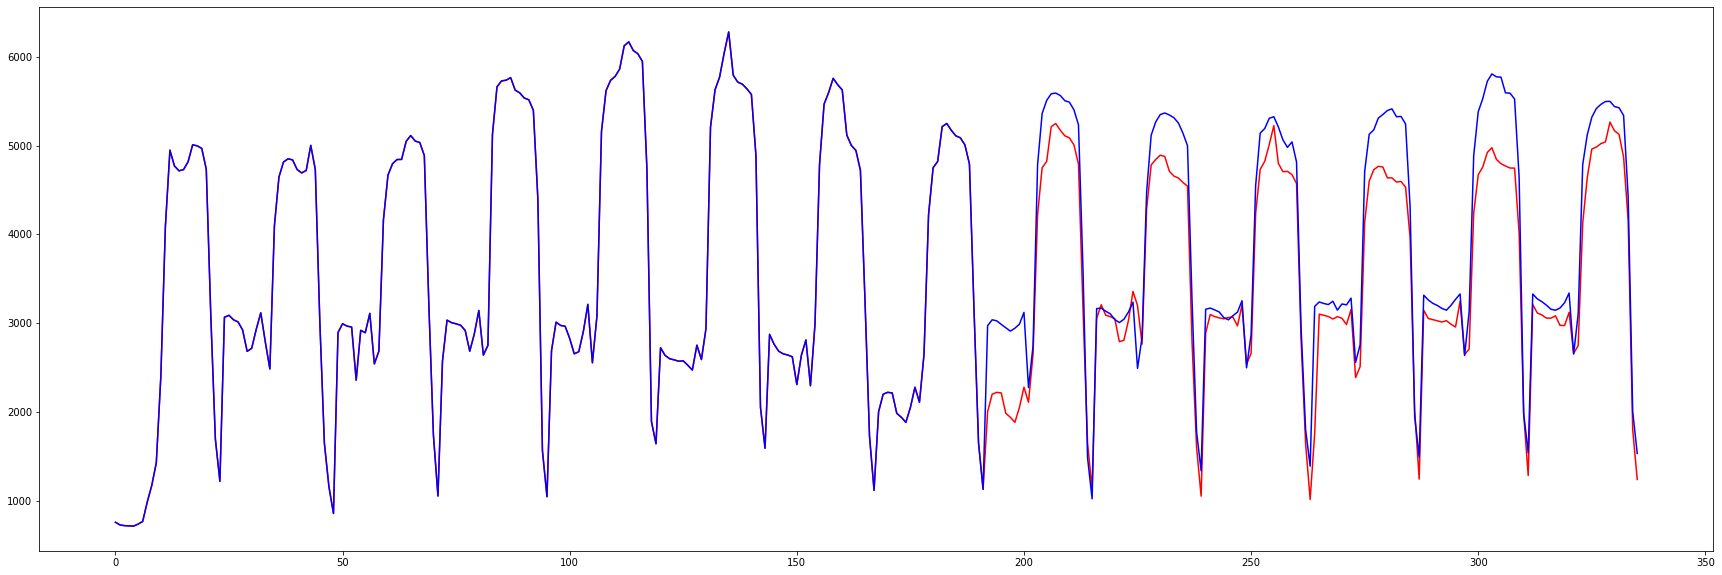

8.994745894282019


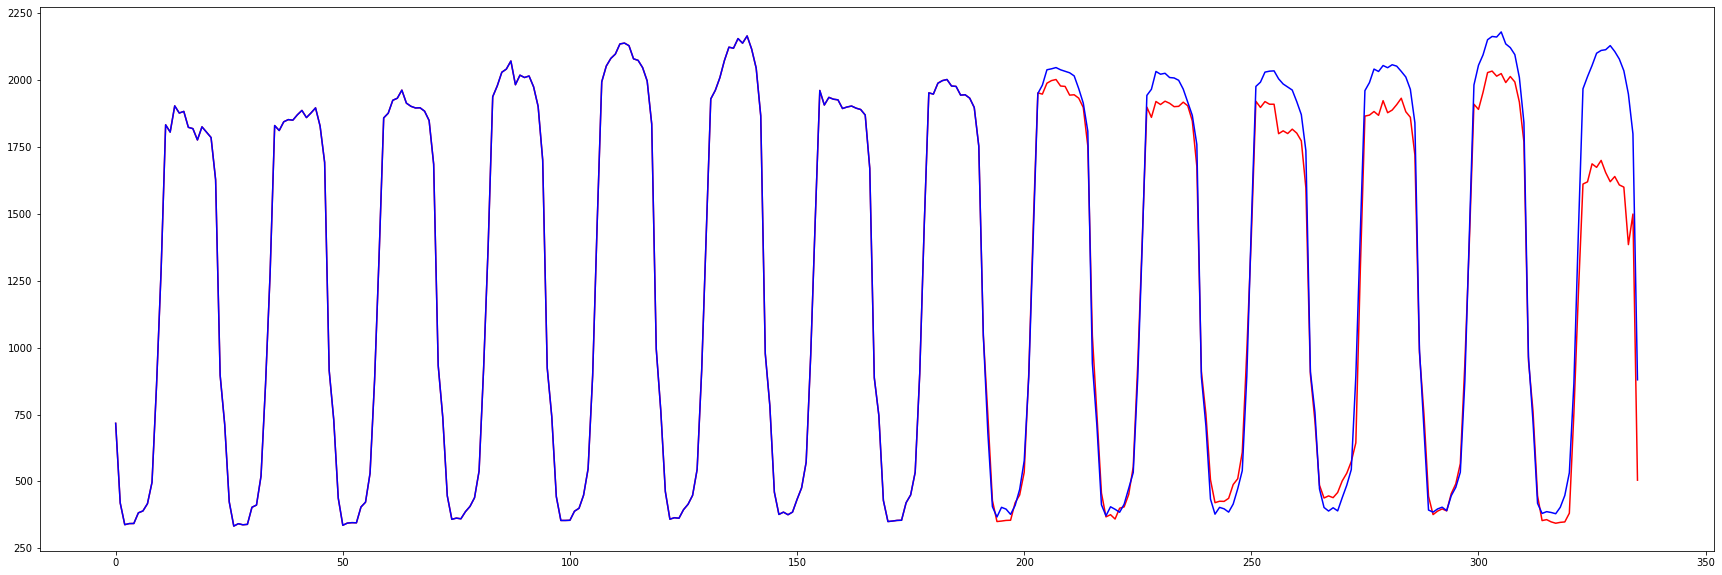

7.267716143865565


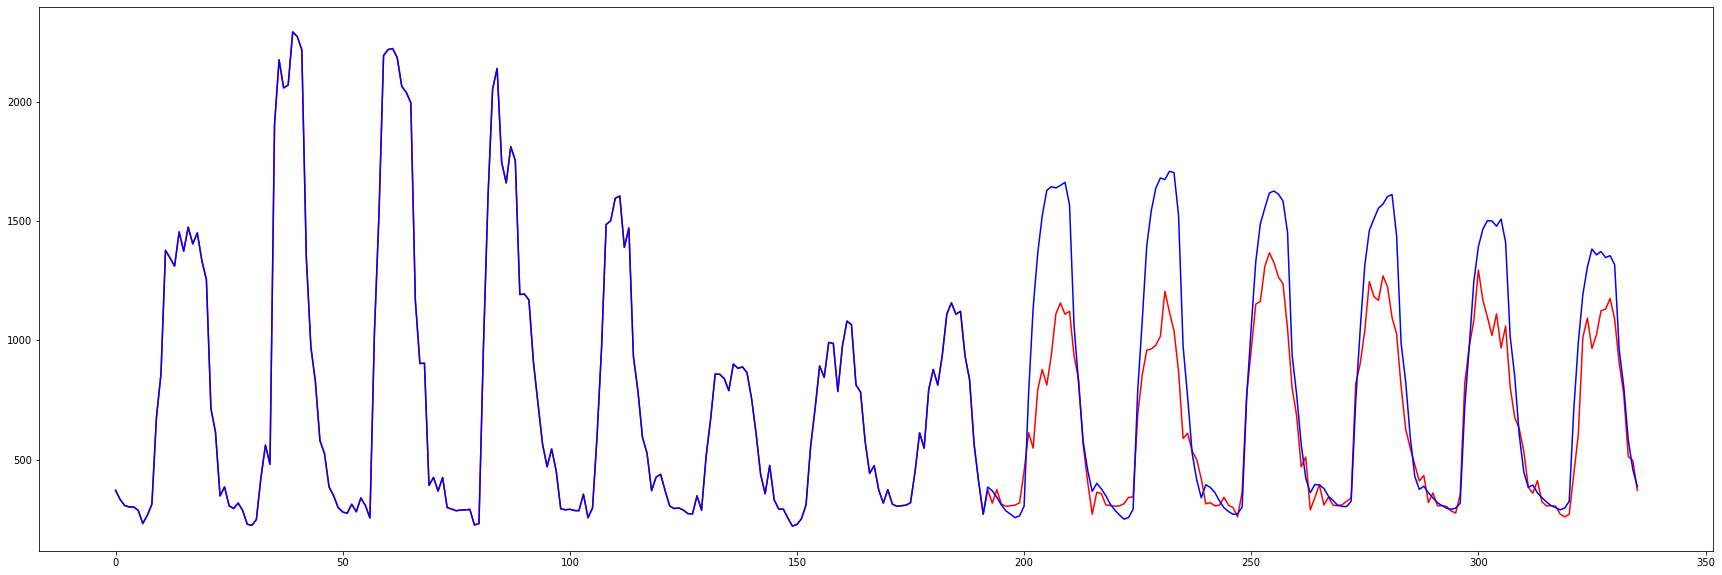

16.39675909587816


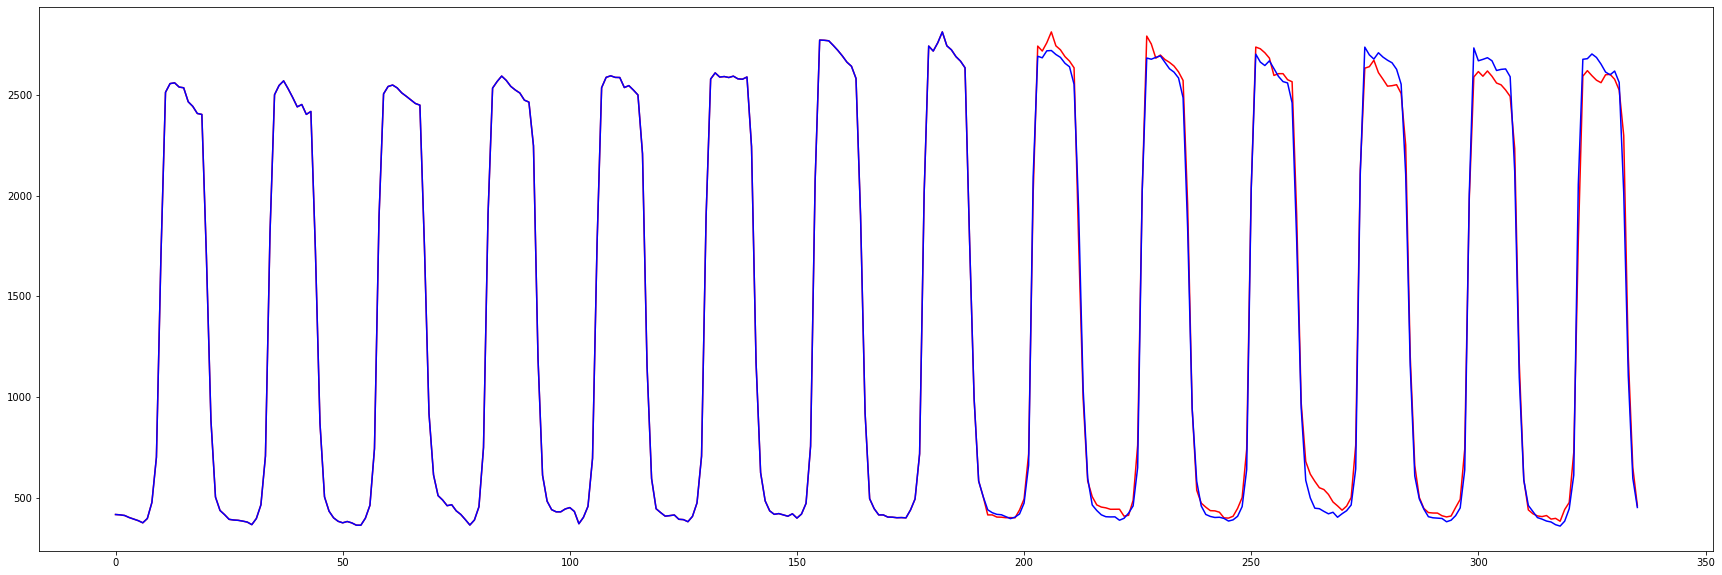

4.594366711017396


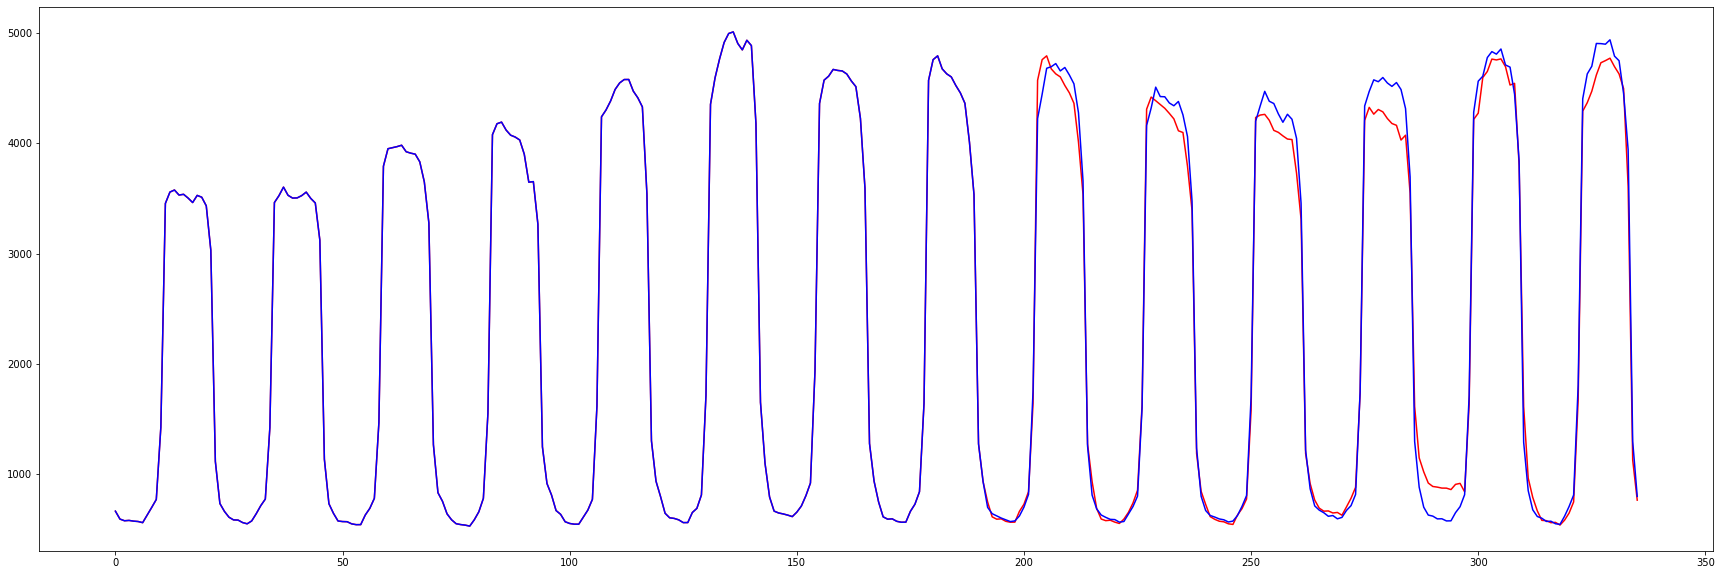

5.789525770053918


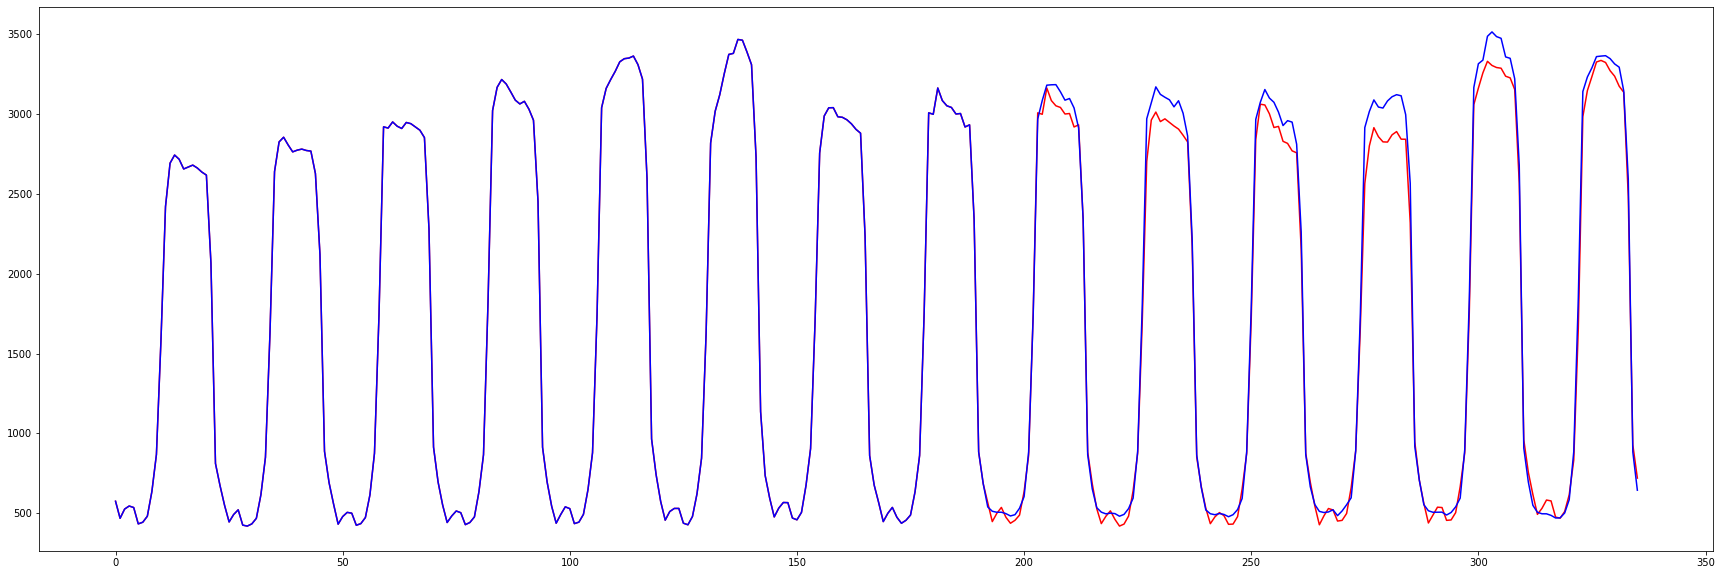

4.554168658561841


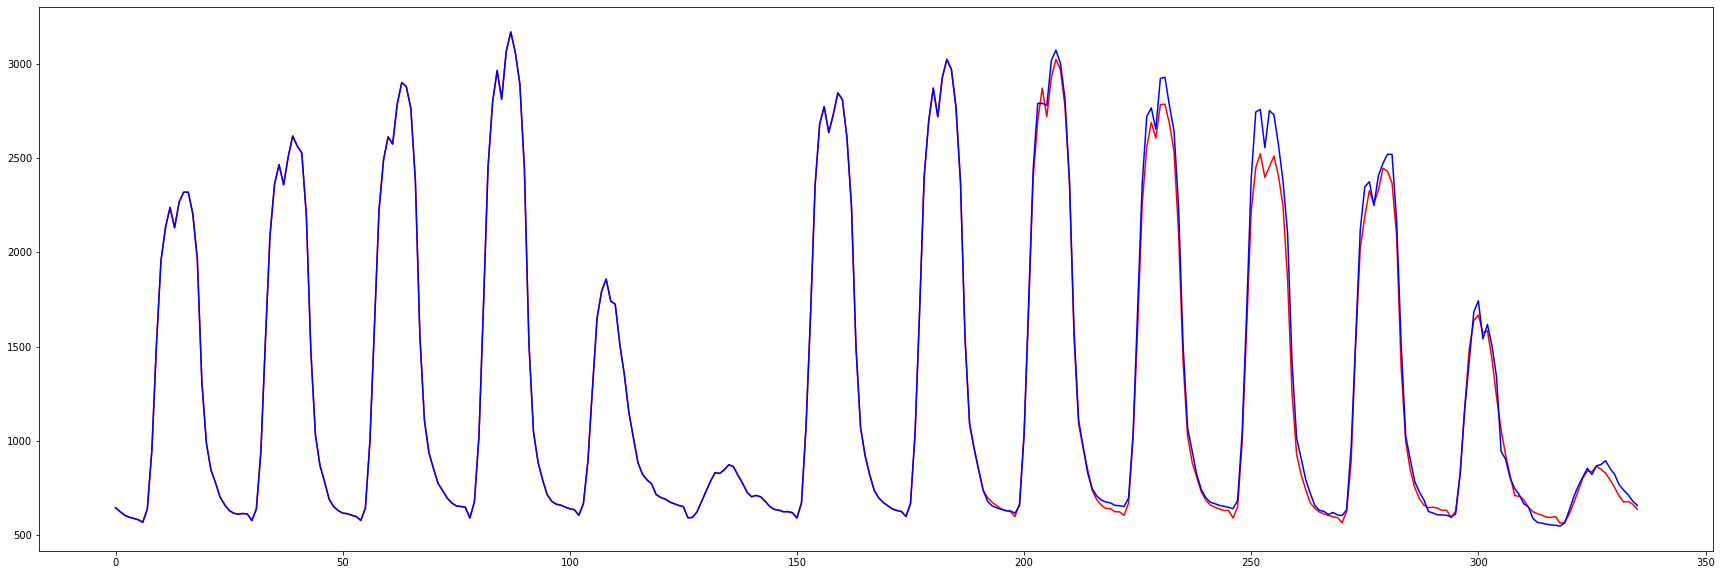

3.604589395272188


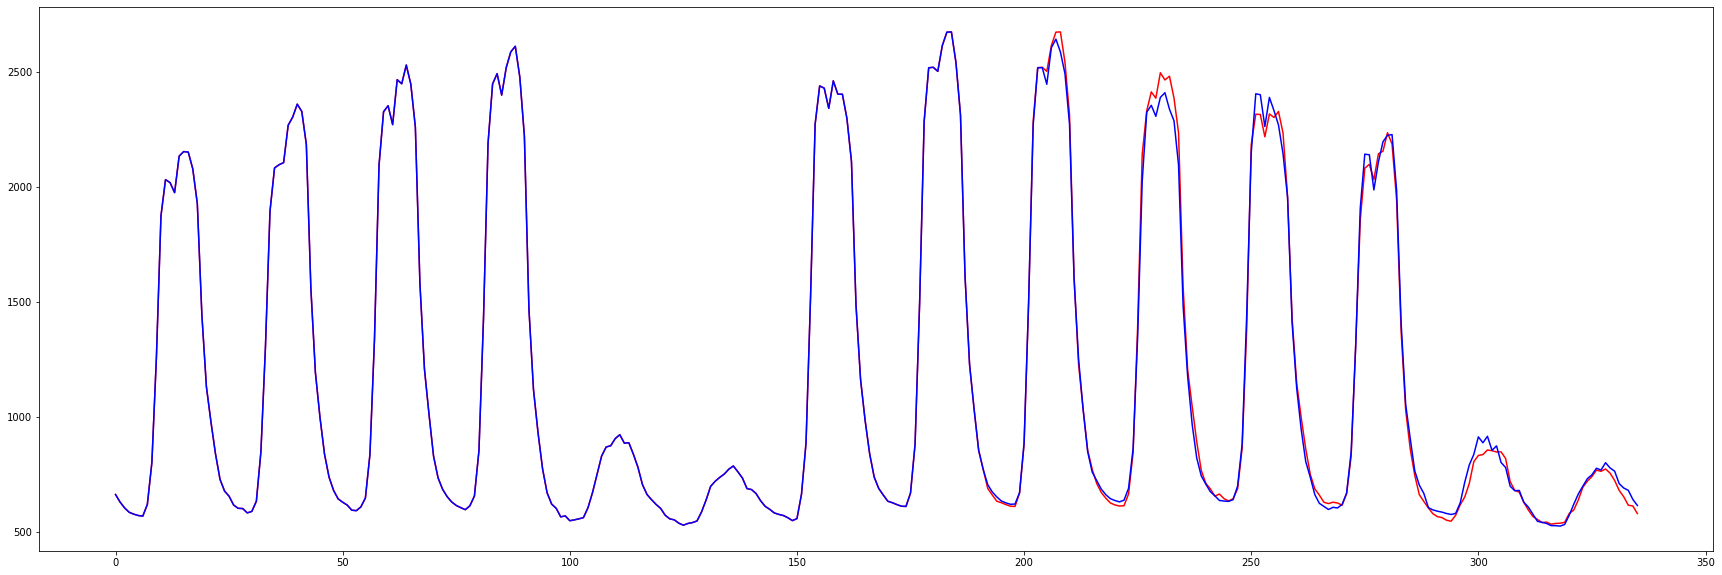

2.4106859594825454


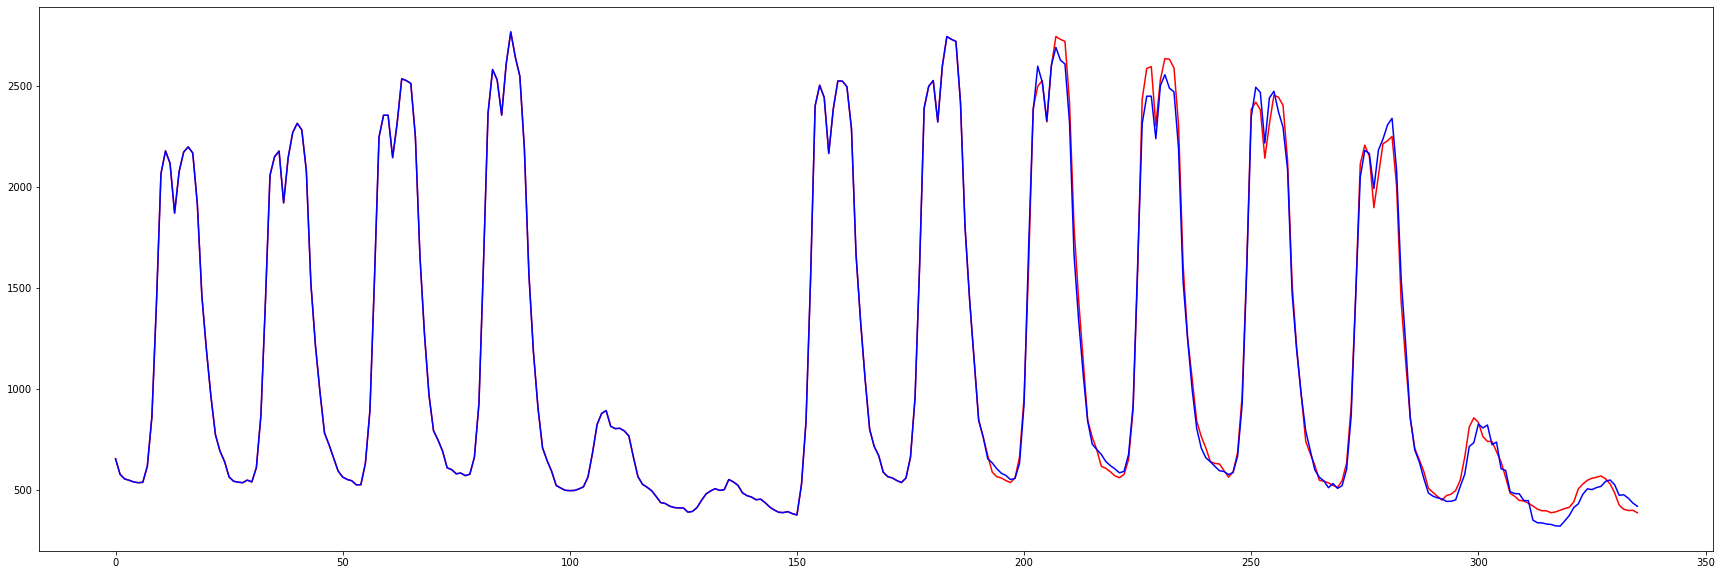

4.583793292283893


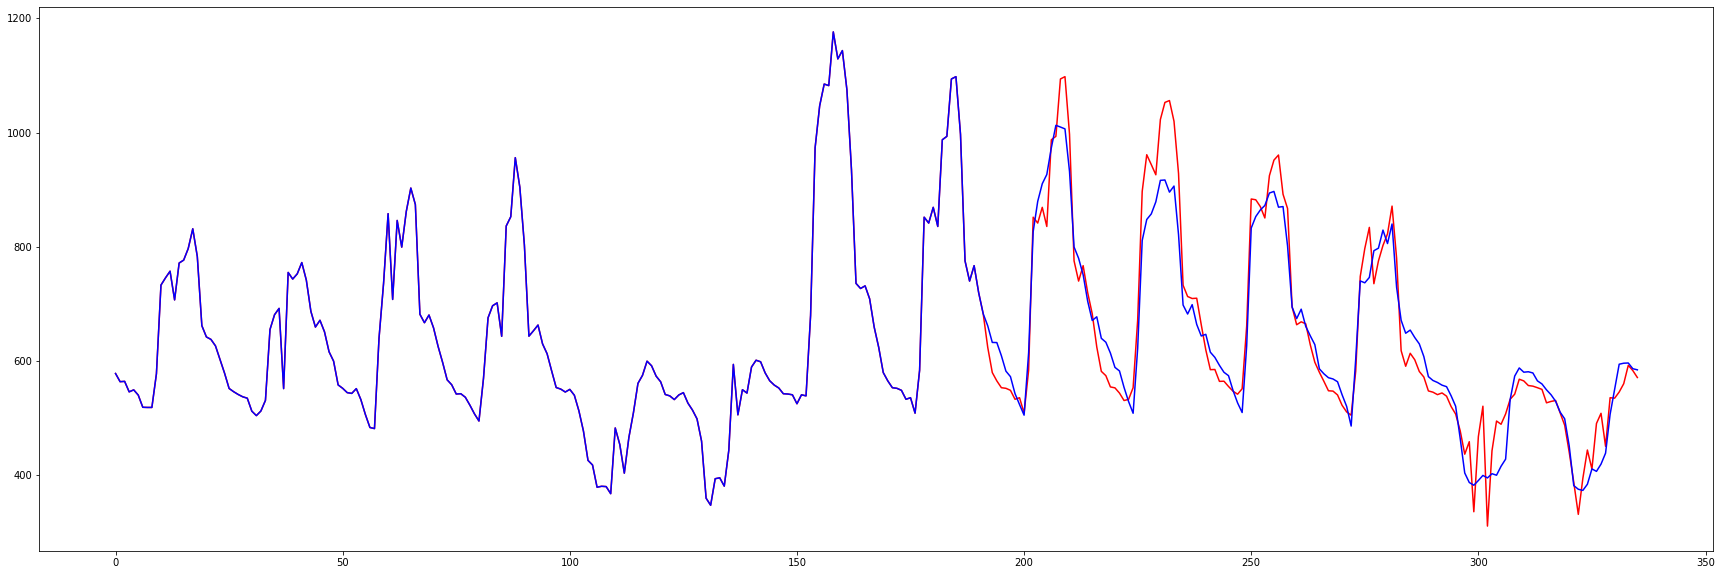

5.115213402022029


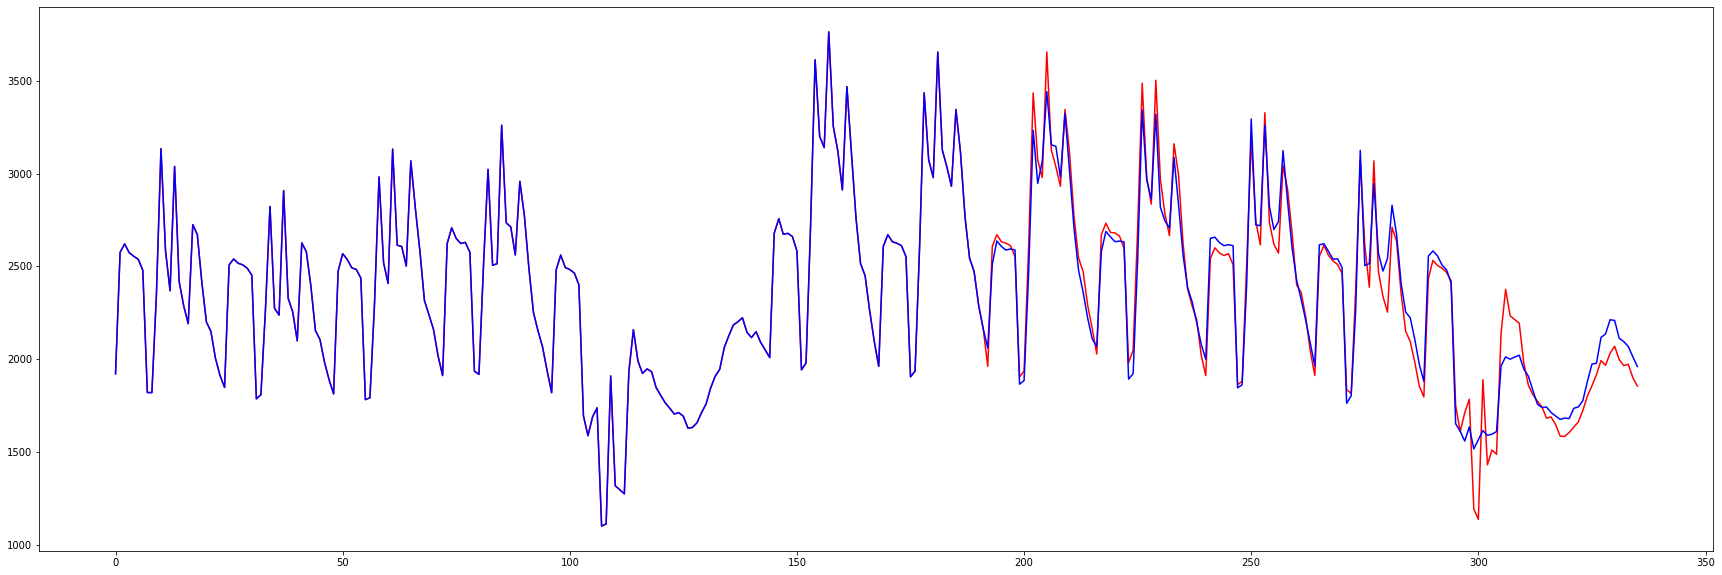

3.492010345954142


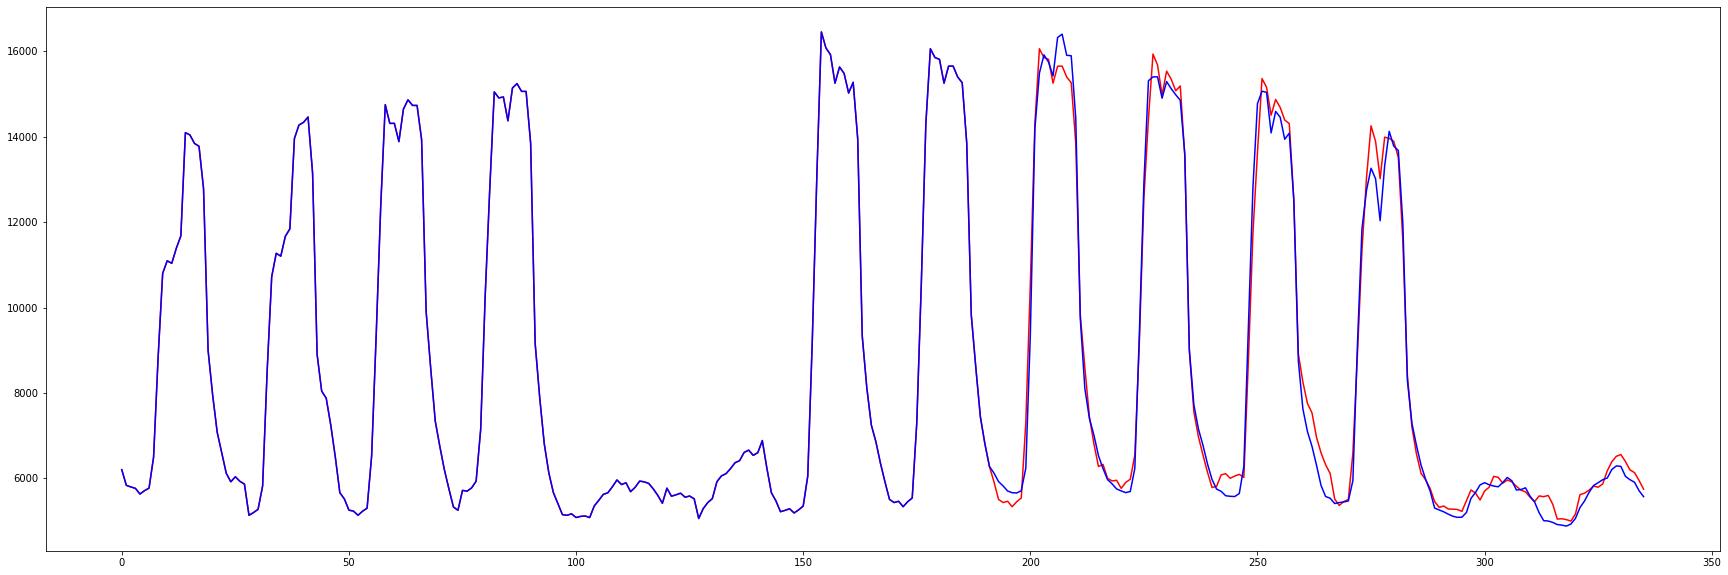

3.1769323039625377


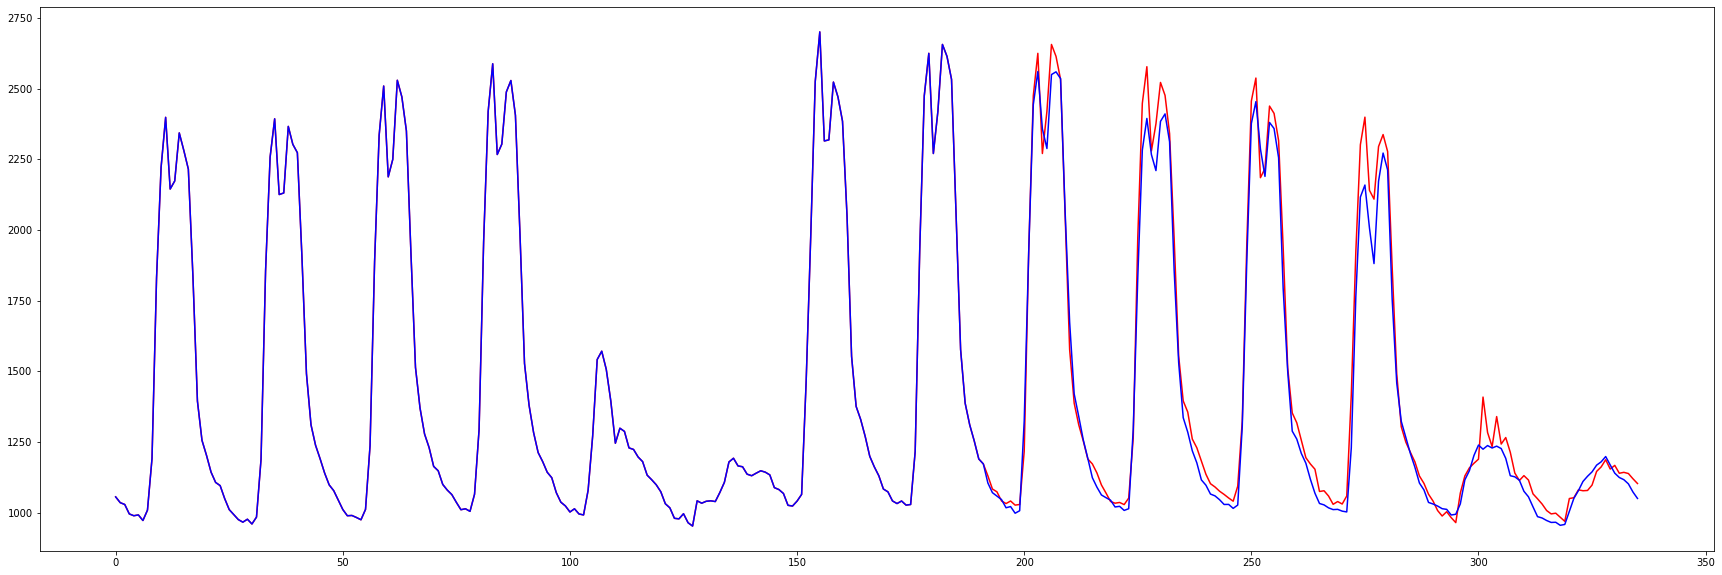

2.951829495557185


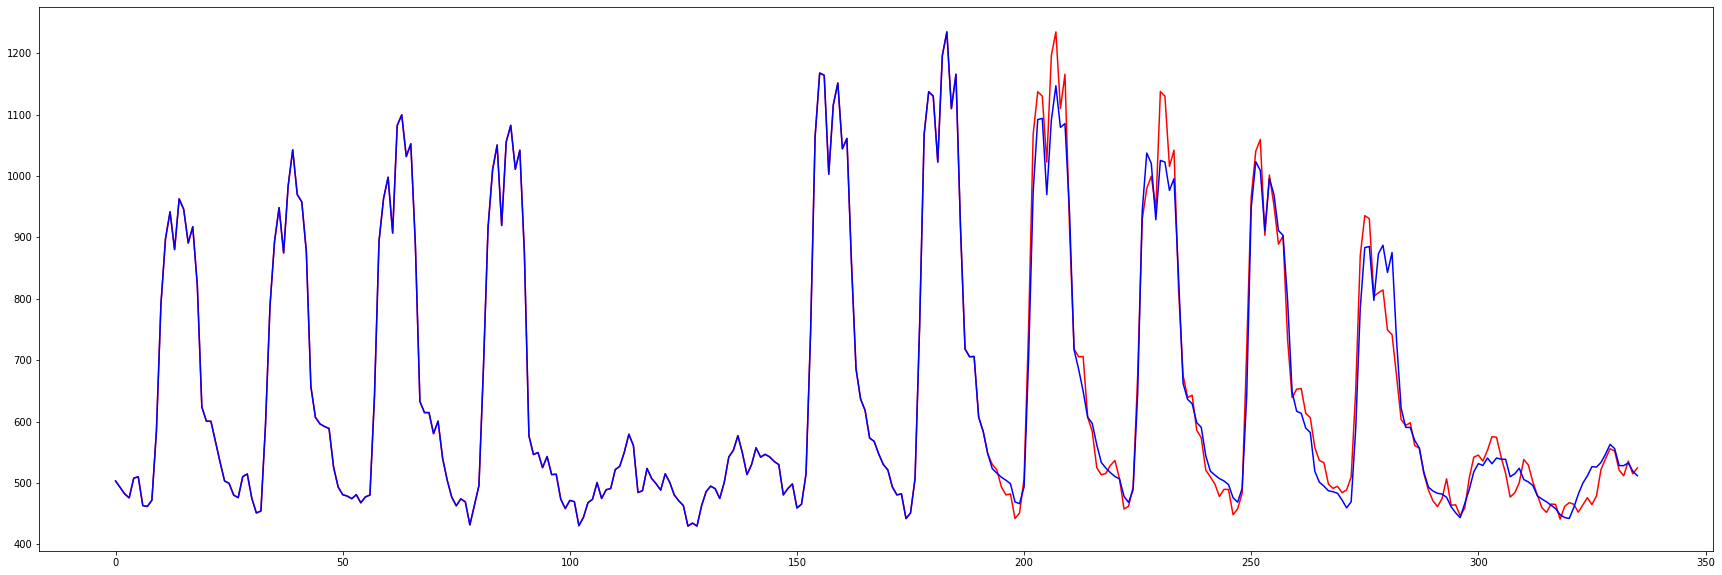

3.357198988815099


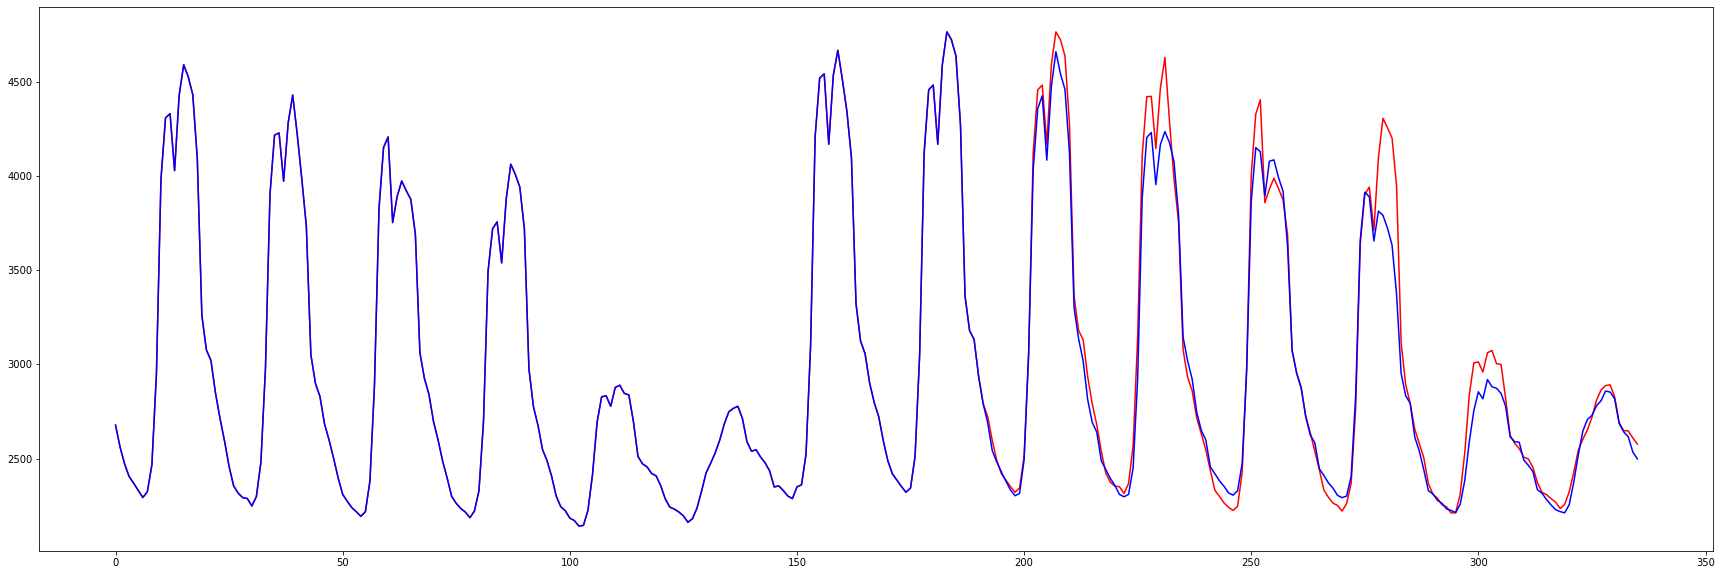

2.2469335820257


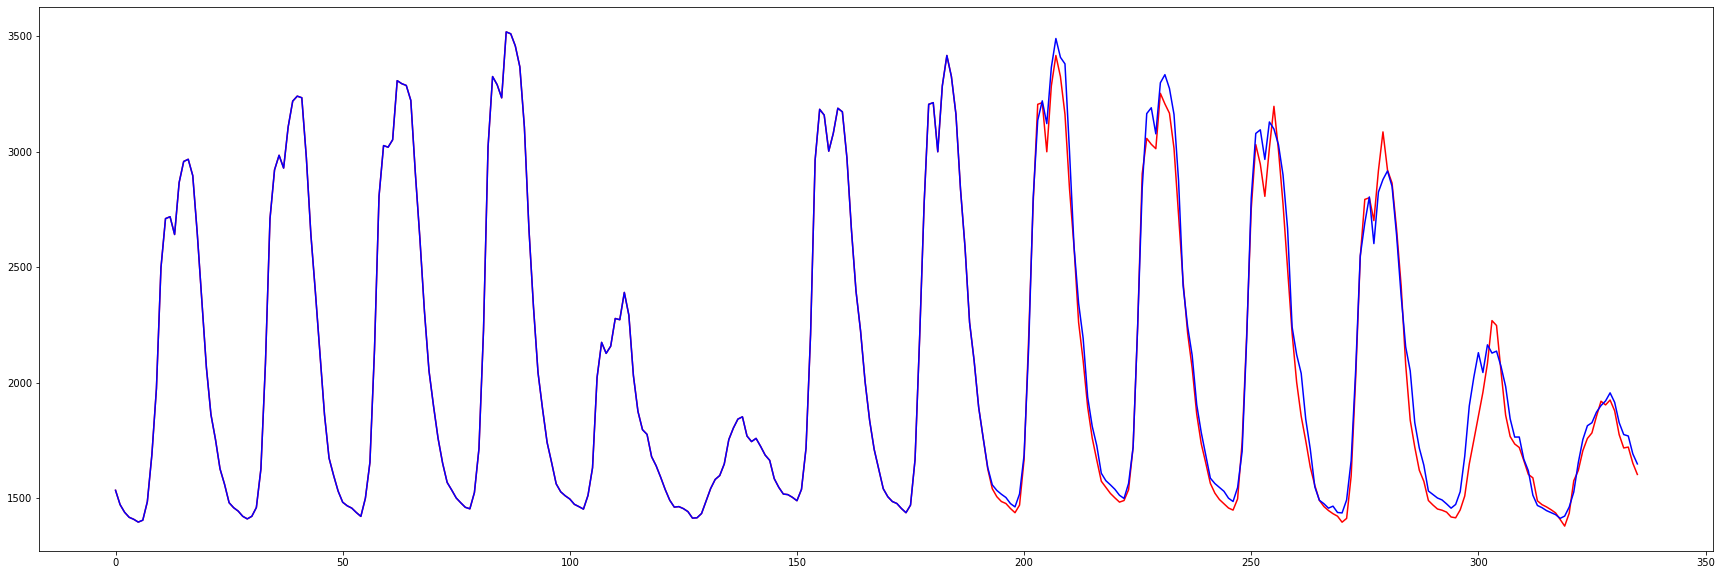

2.5880349605507136


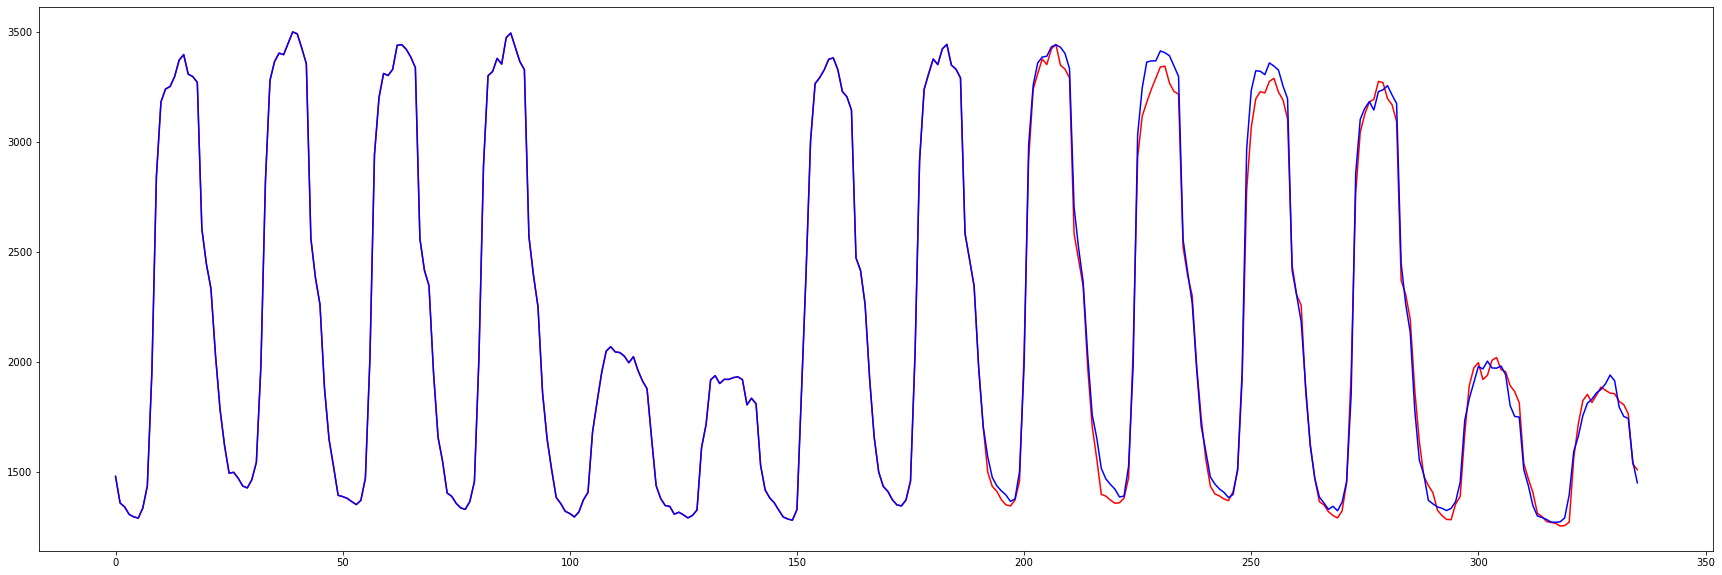

2.0991933187667935


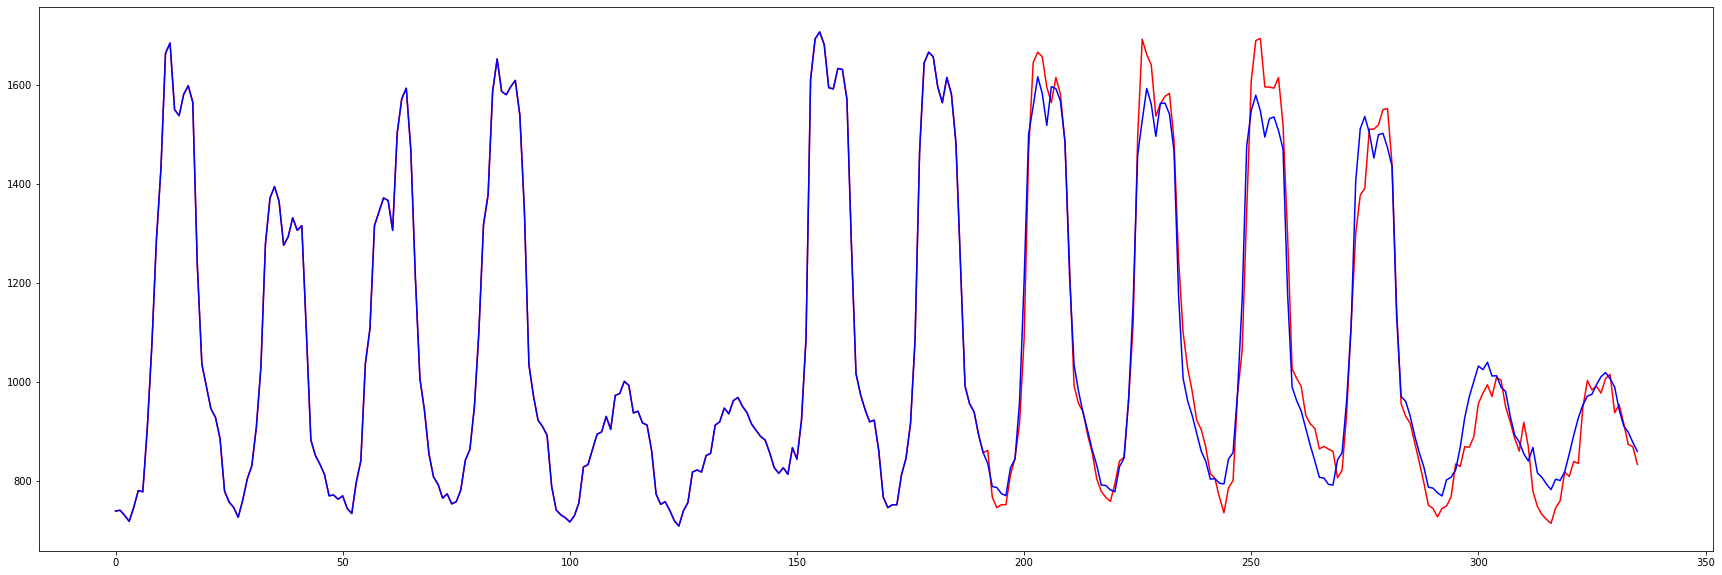

3.5520029497371963


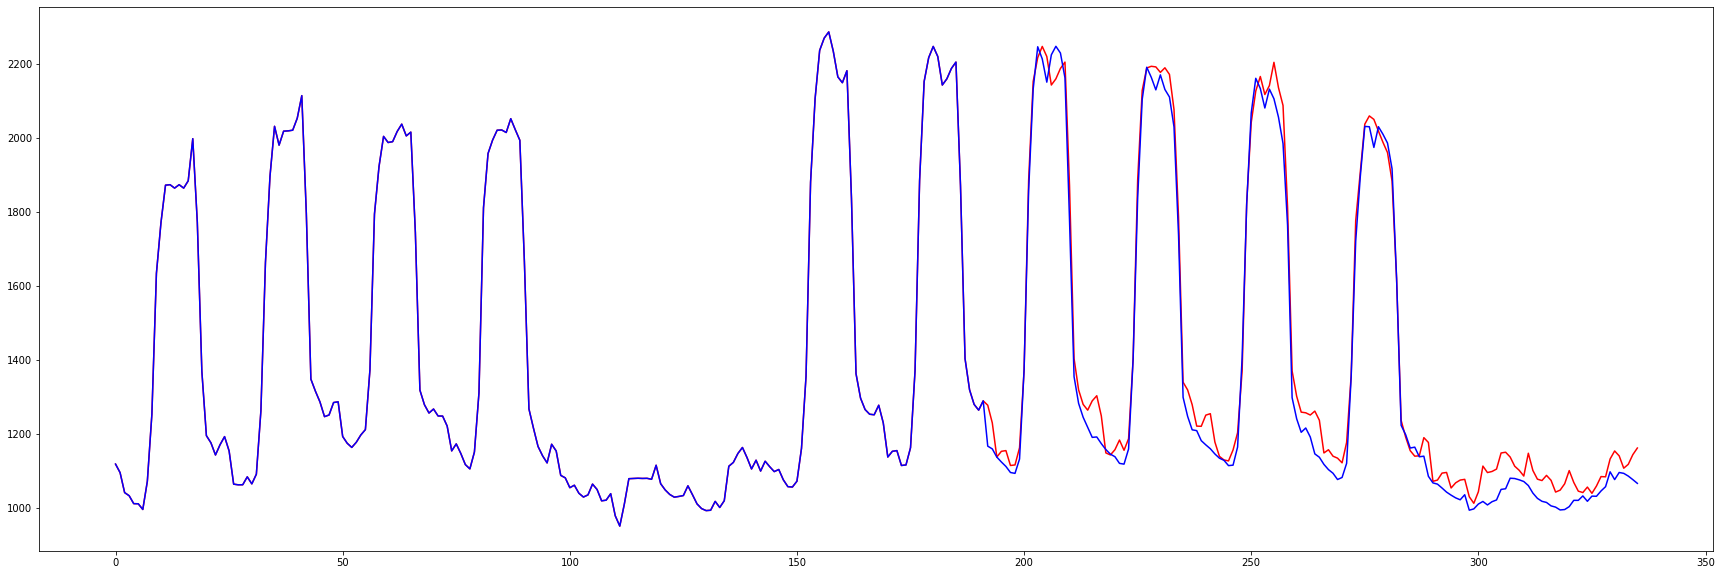

2.9809292869742783


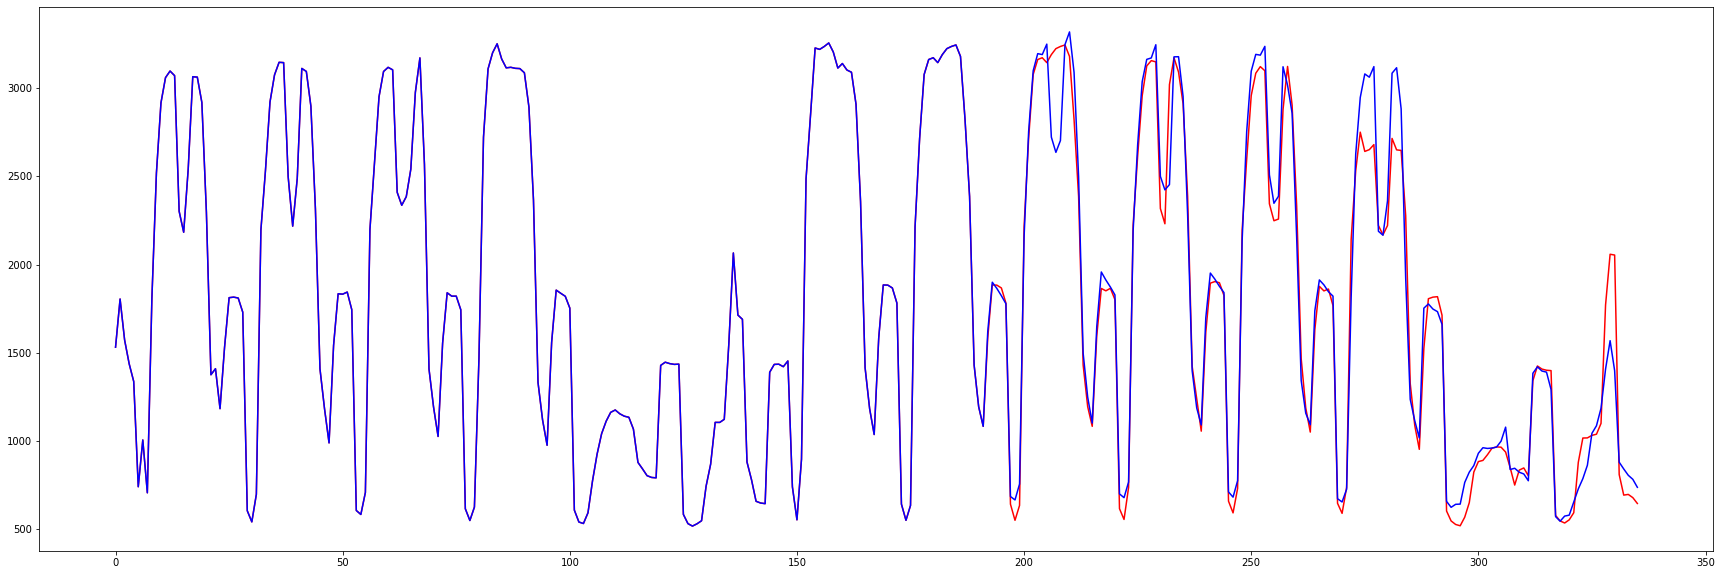

6.082251407812707


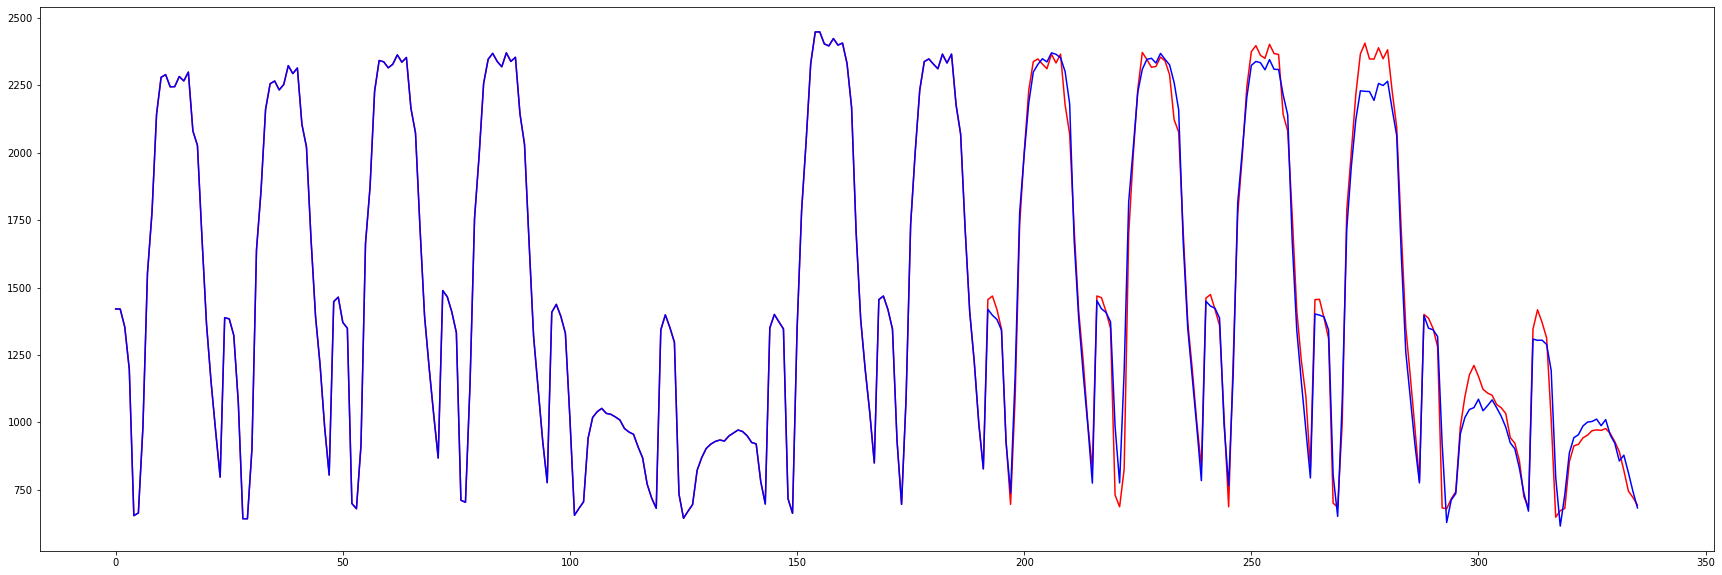

3.819234906759481


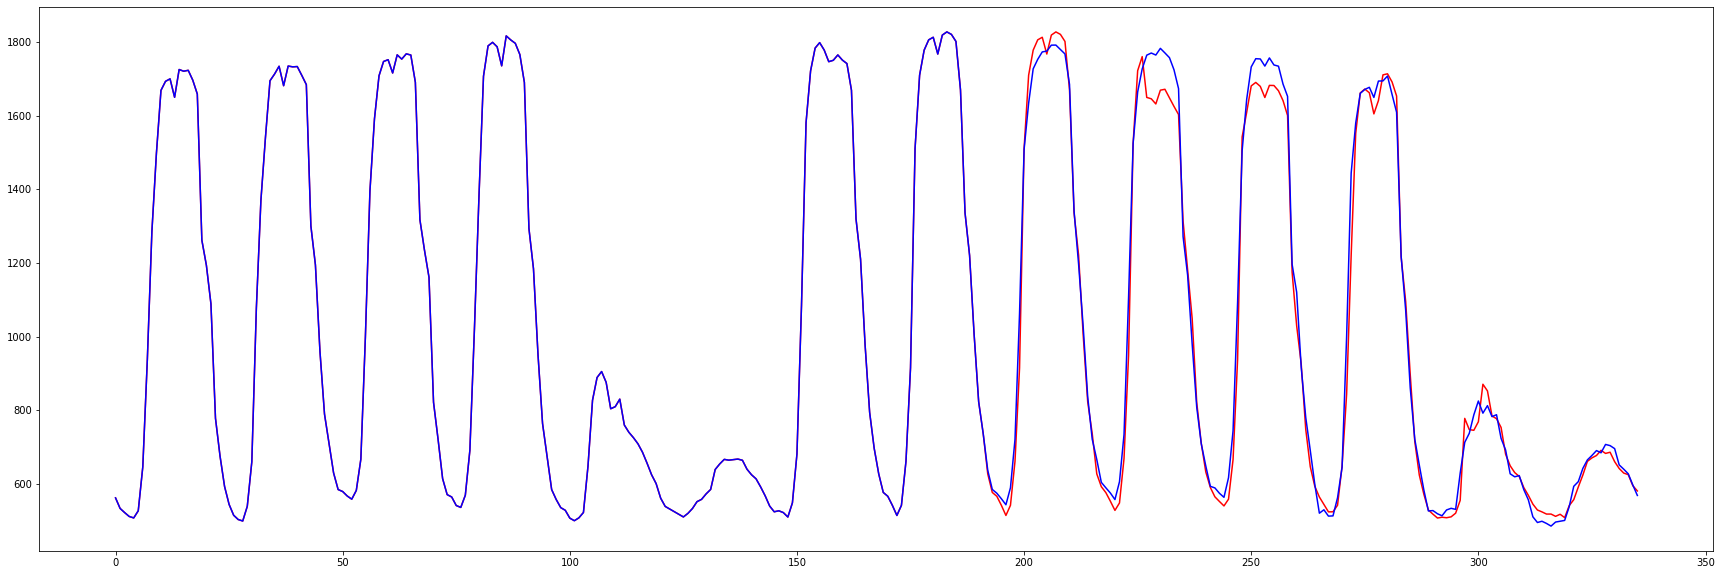

3.259500831432089


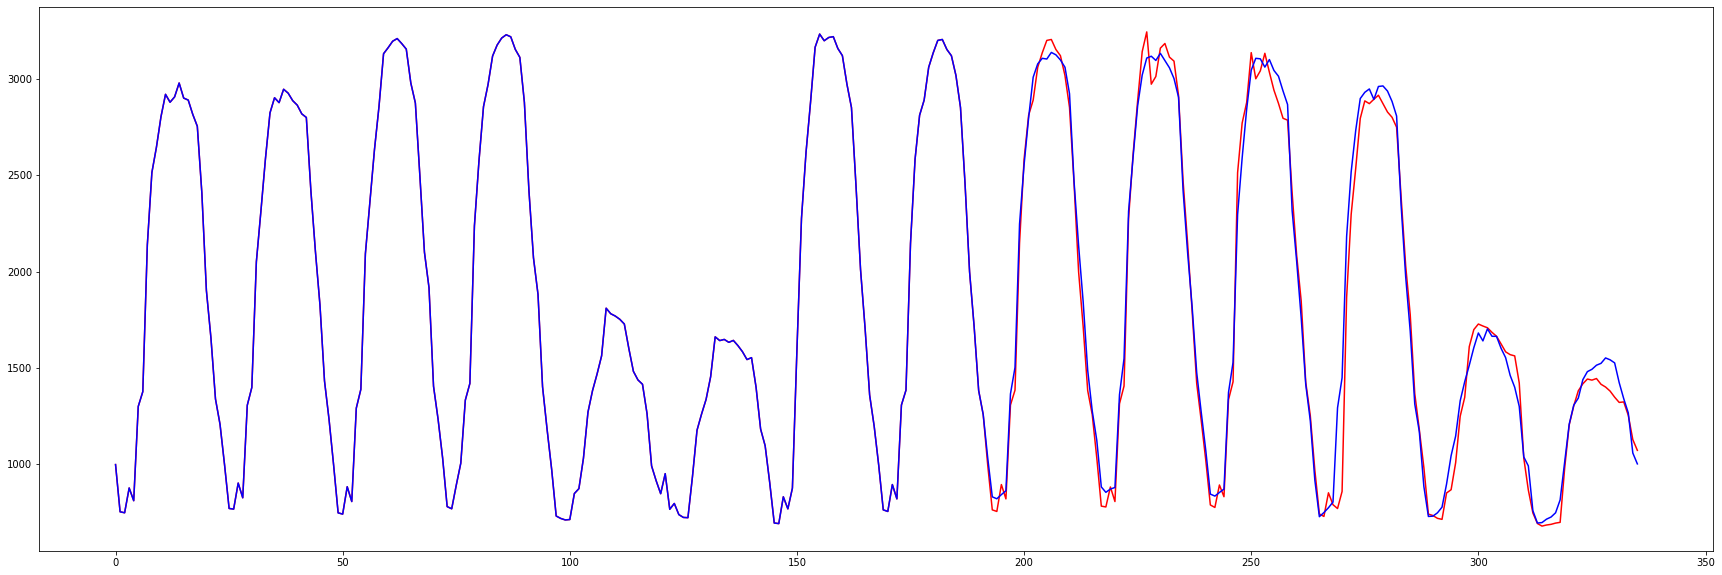

4.3438567211819015


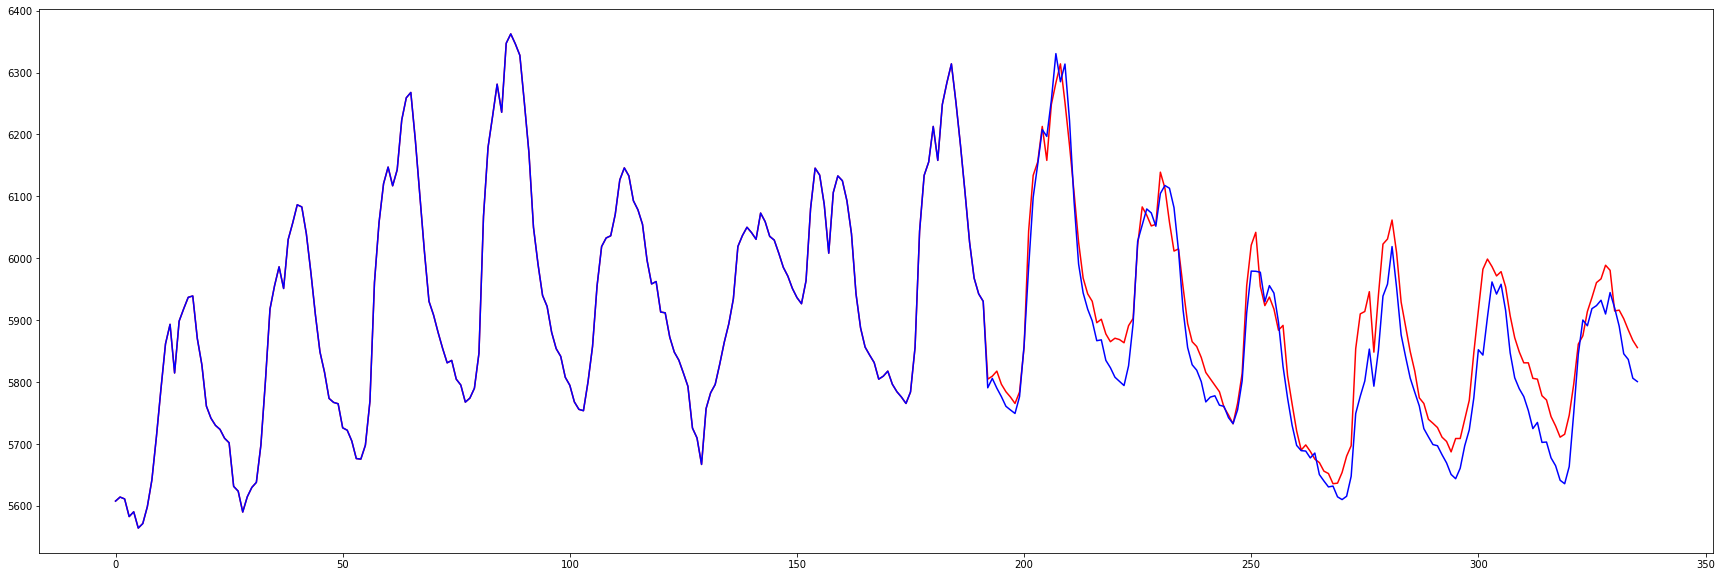

0.5836046795748524


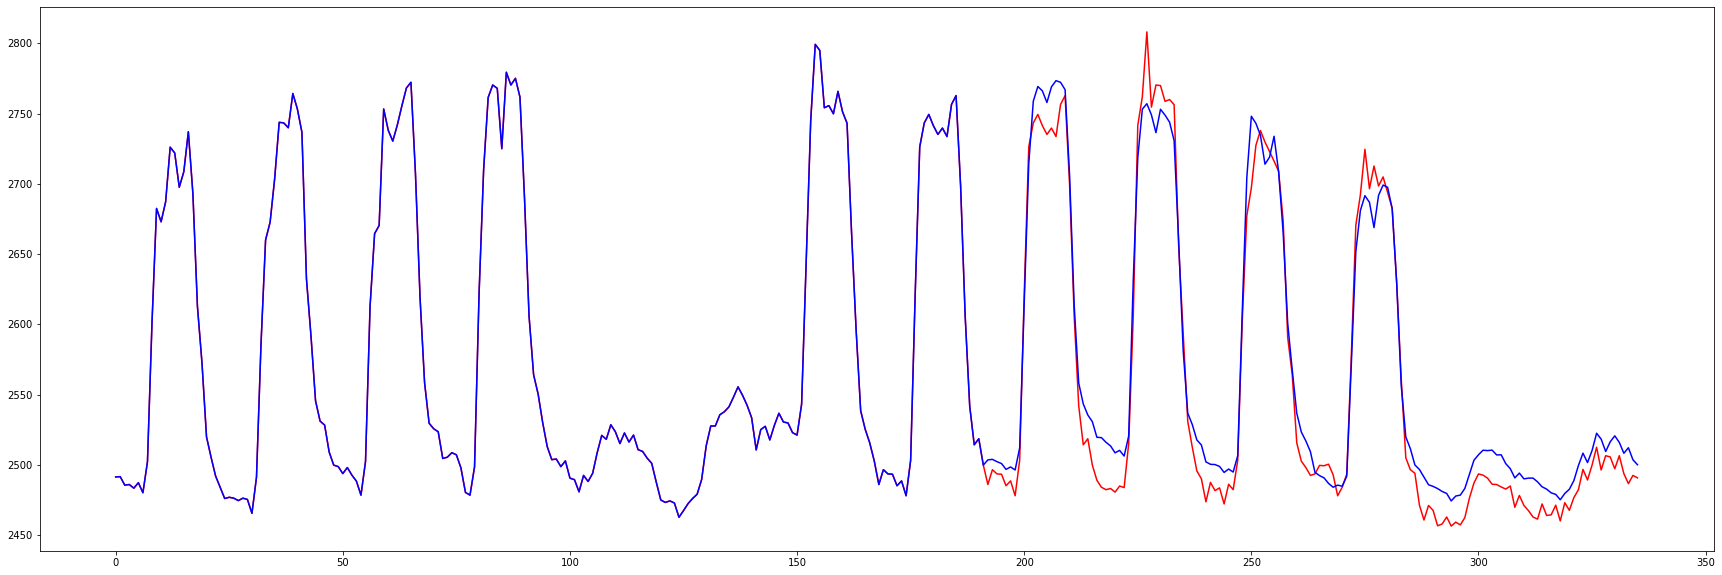

0.5431099940526755


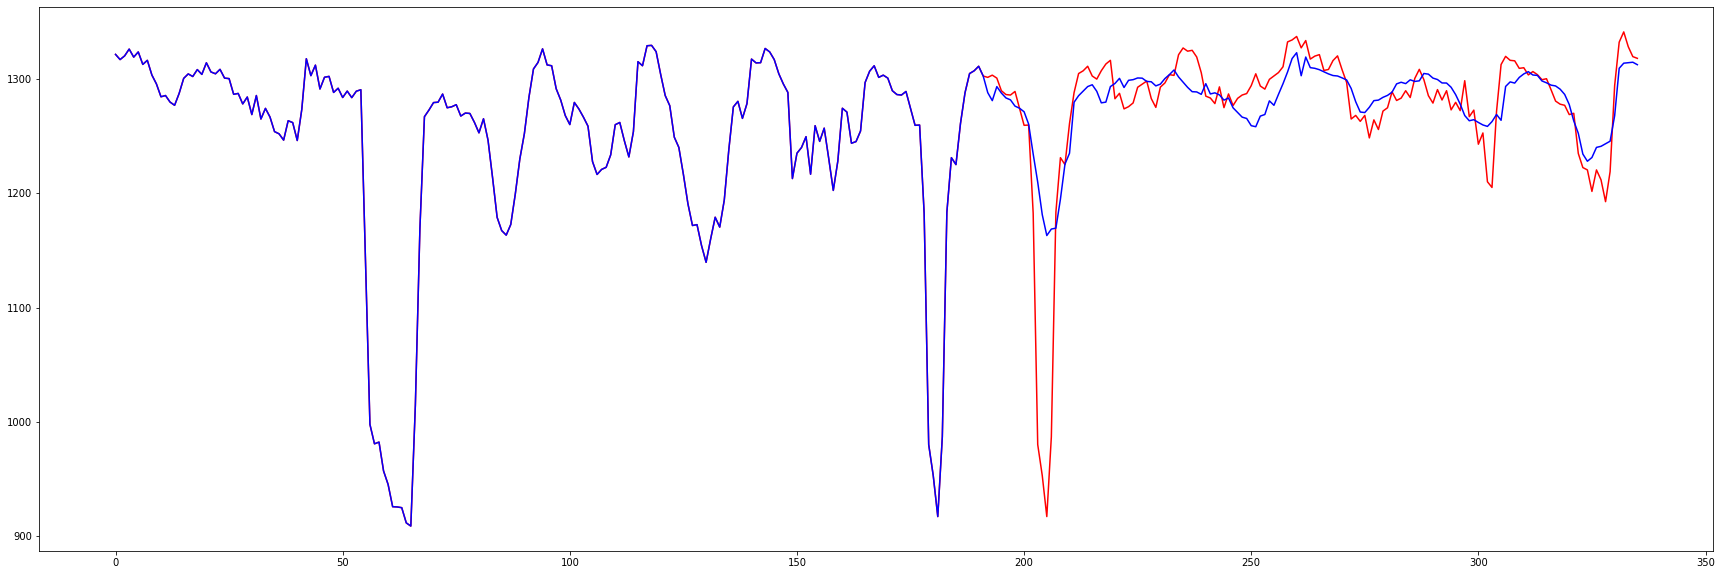

1.4885586583616592


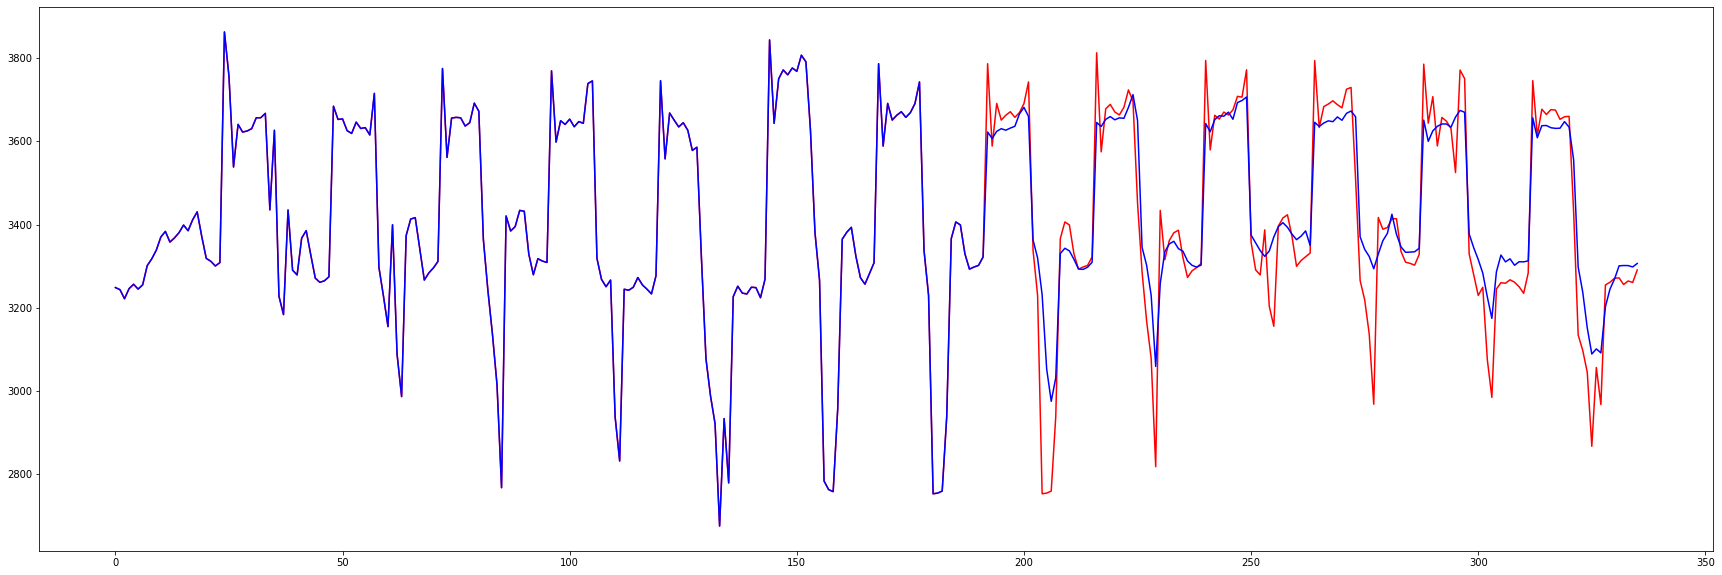

1.6598676641357293


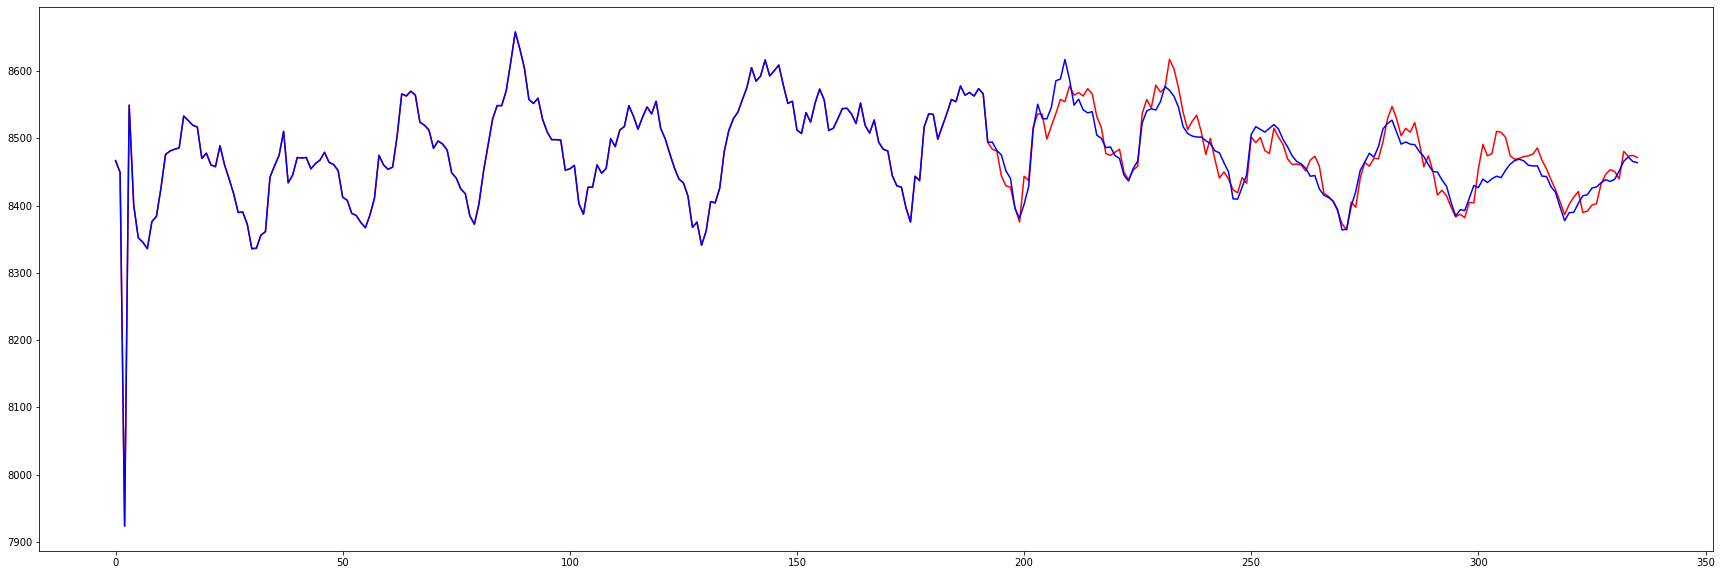

0.1689829841753695


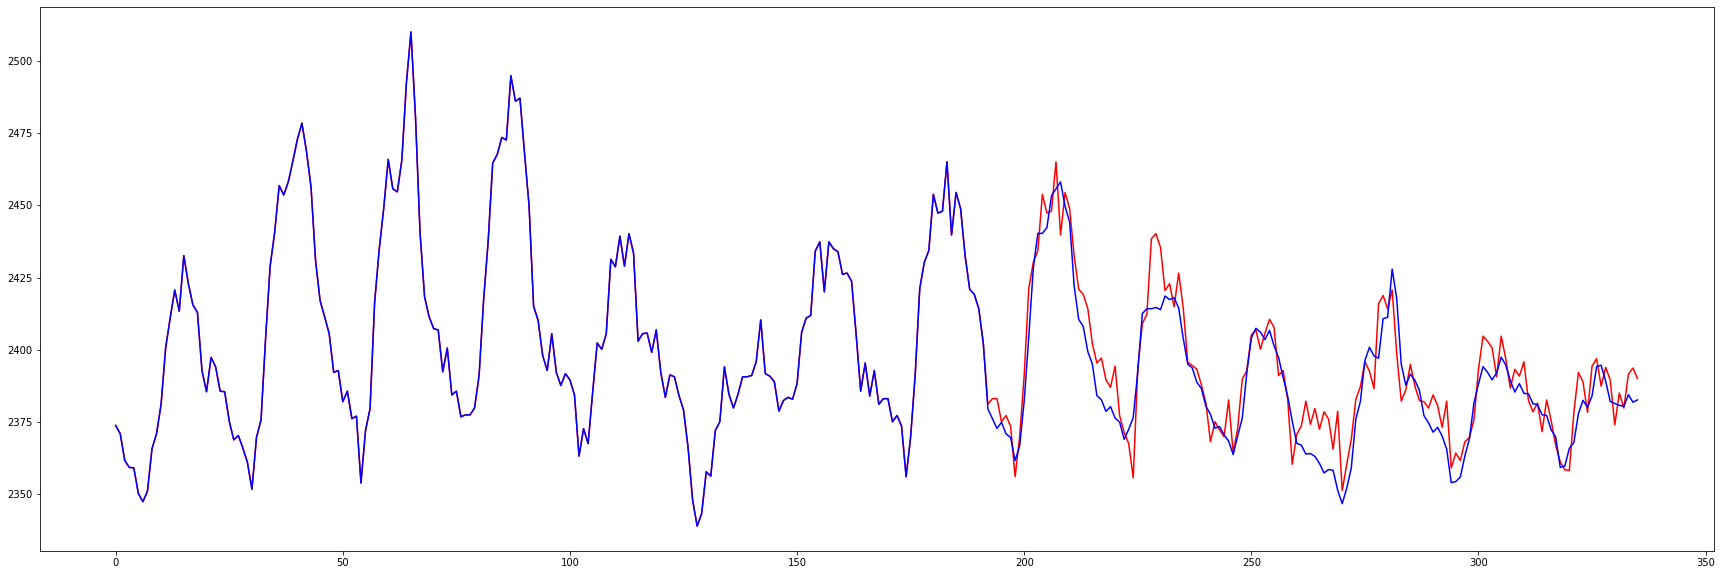

0.262058258552373


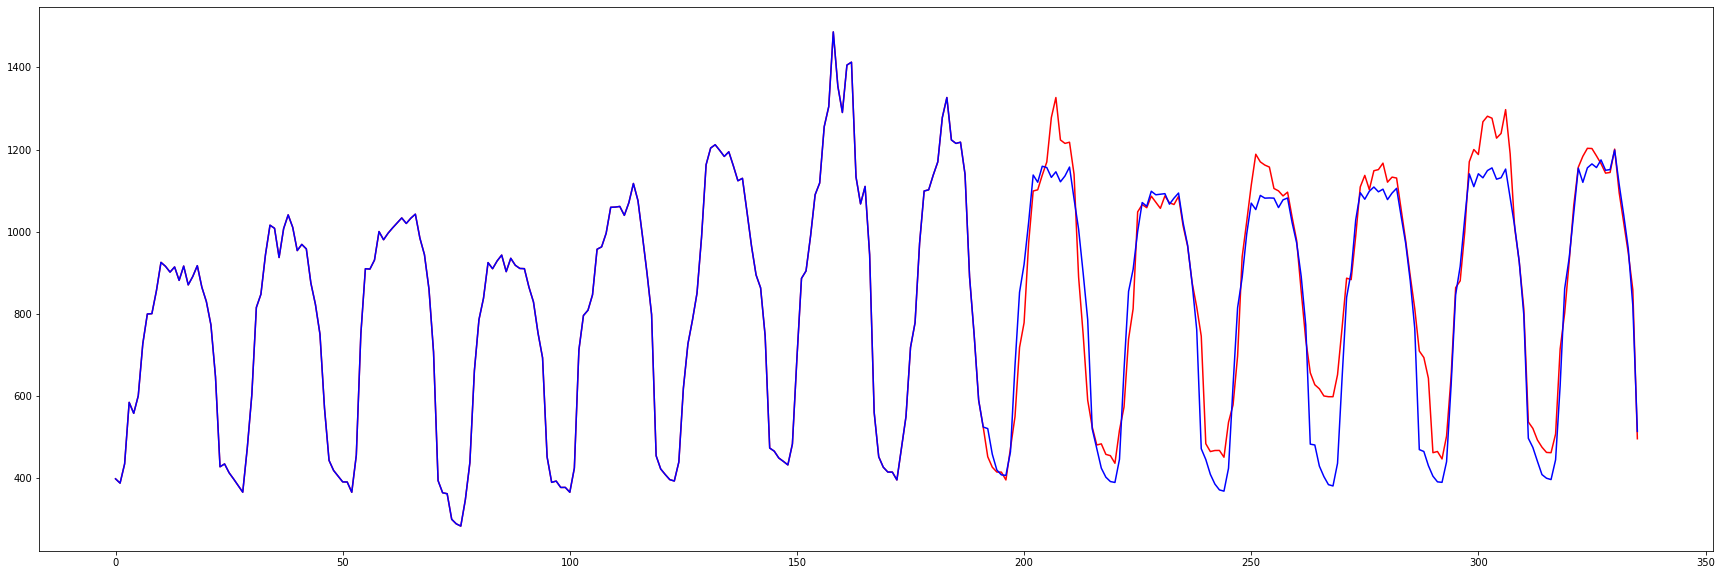

7.901259352386059


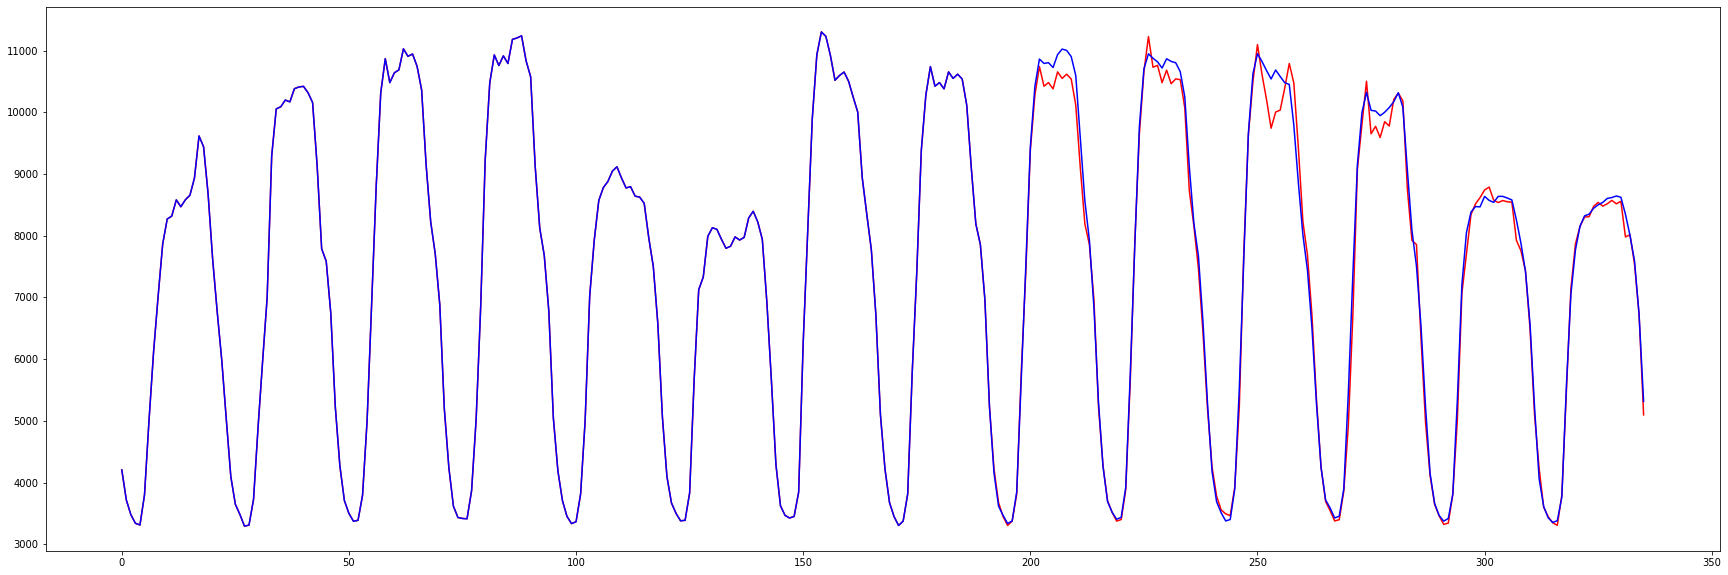

1.7513322746925228


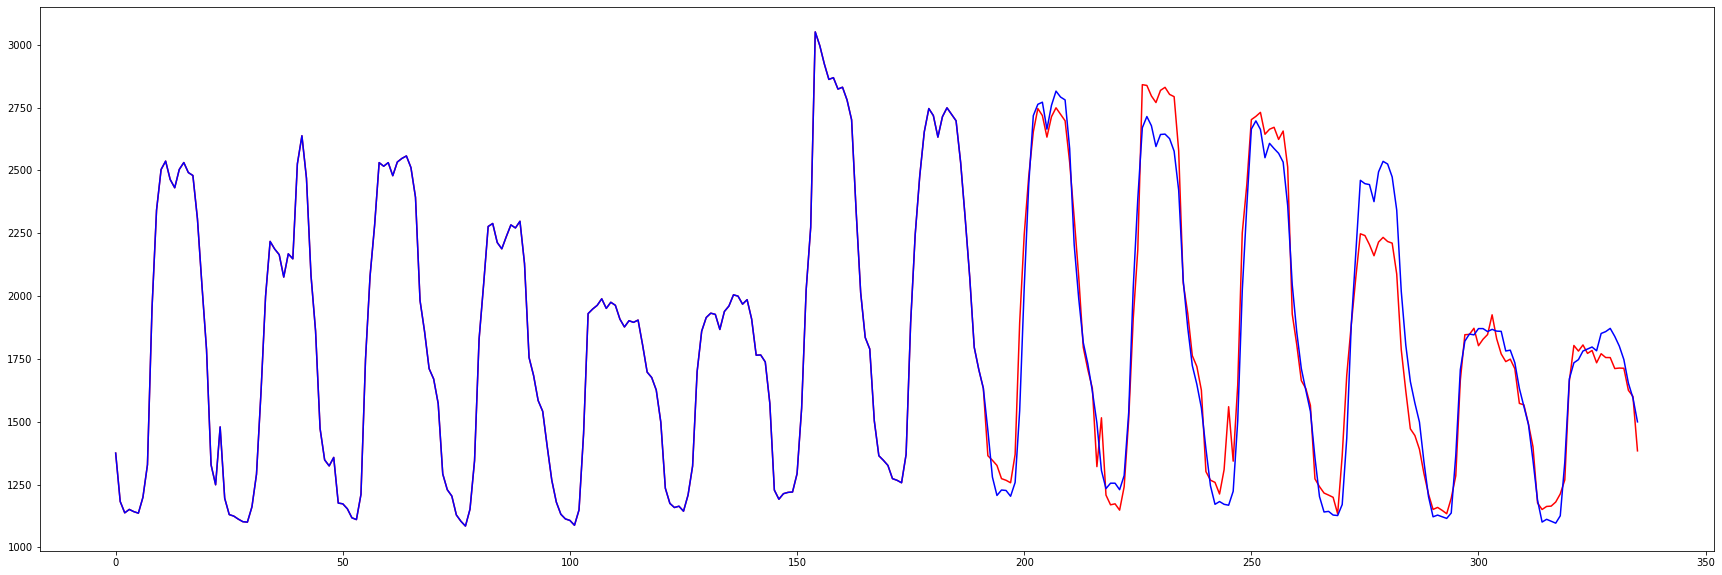

4.381746650237902


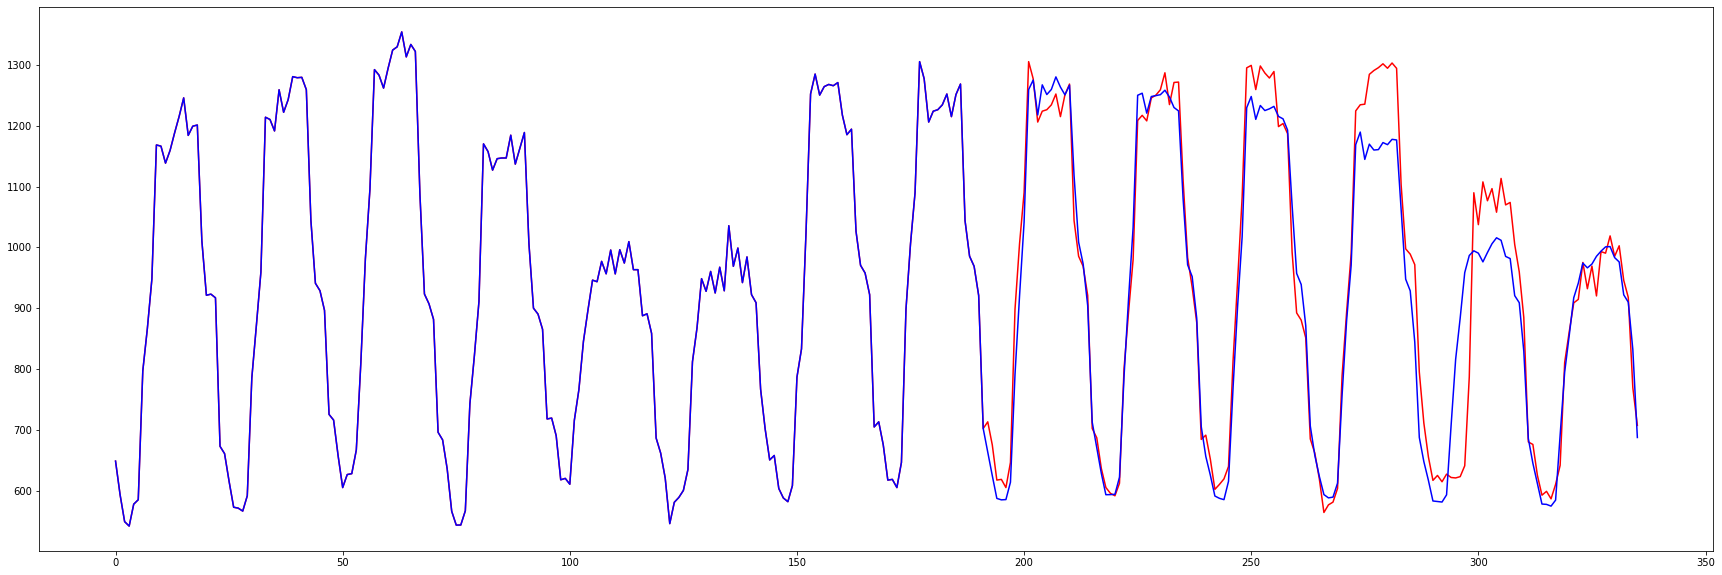

4.300975814377937


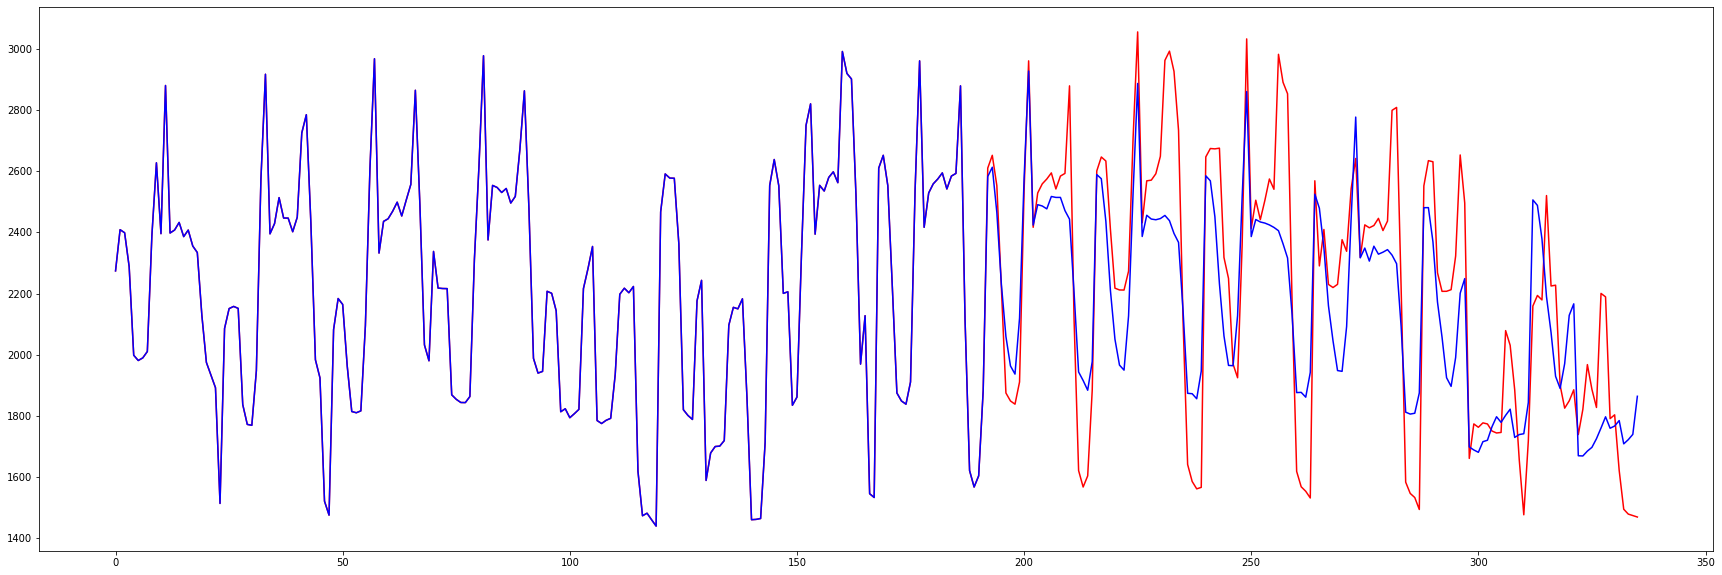

7.7080293890230624


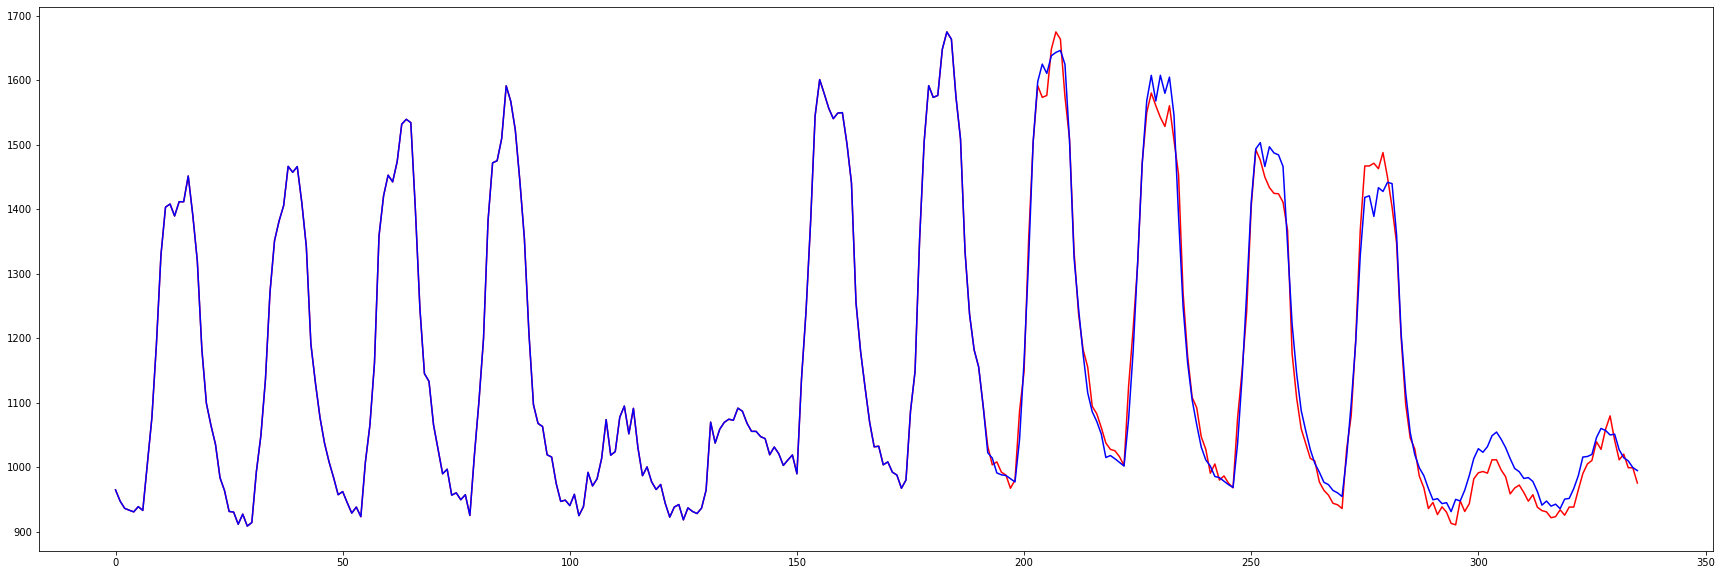

1.6577655004405794


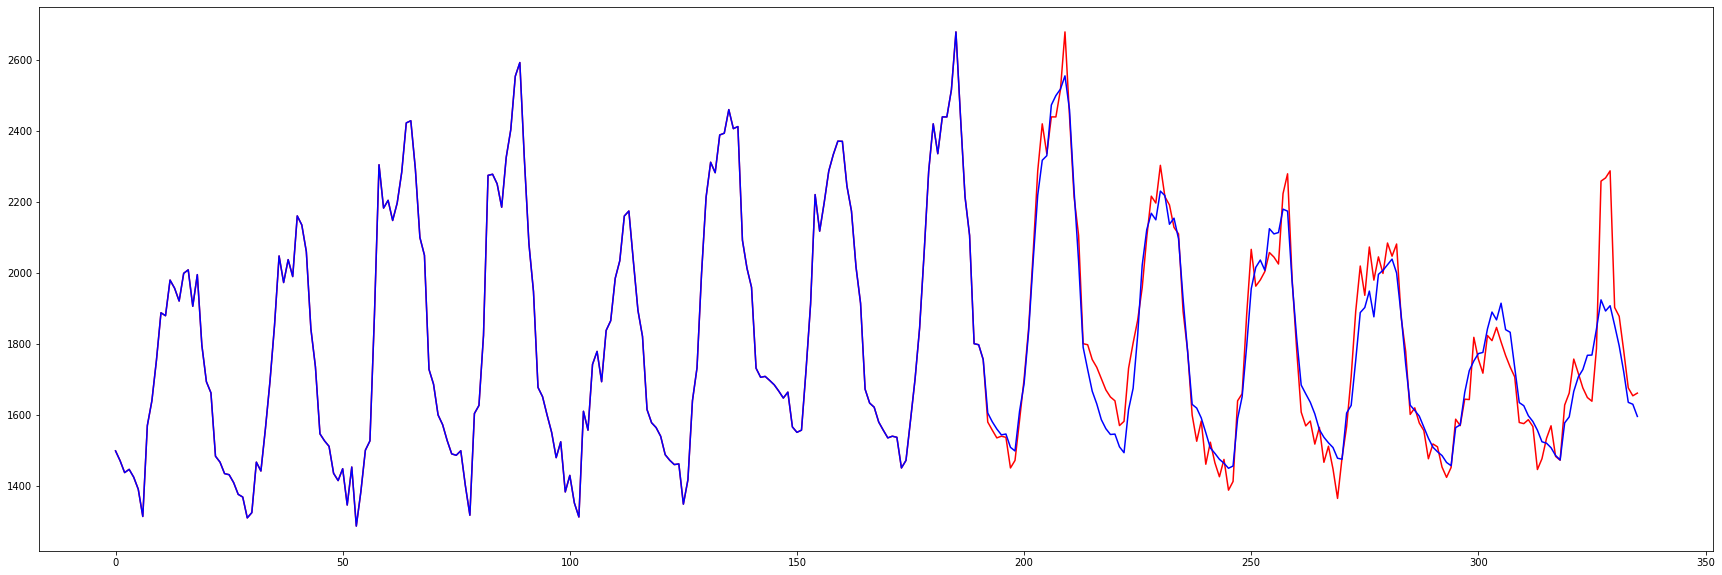

2.7256971606266034


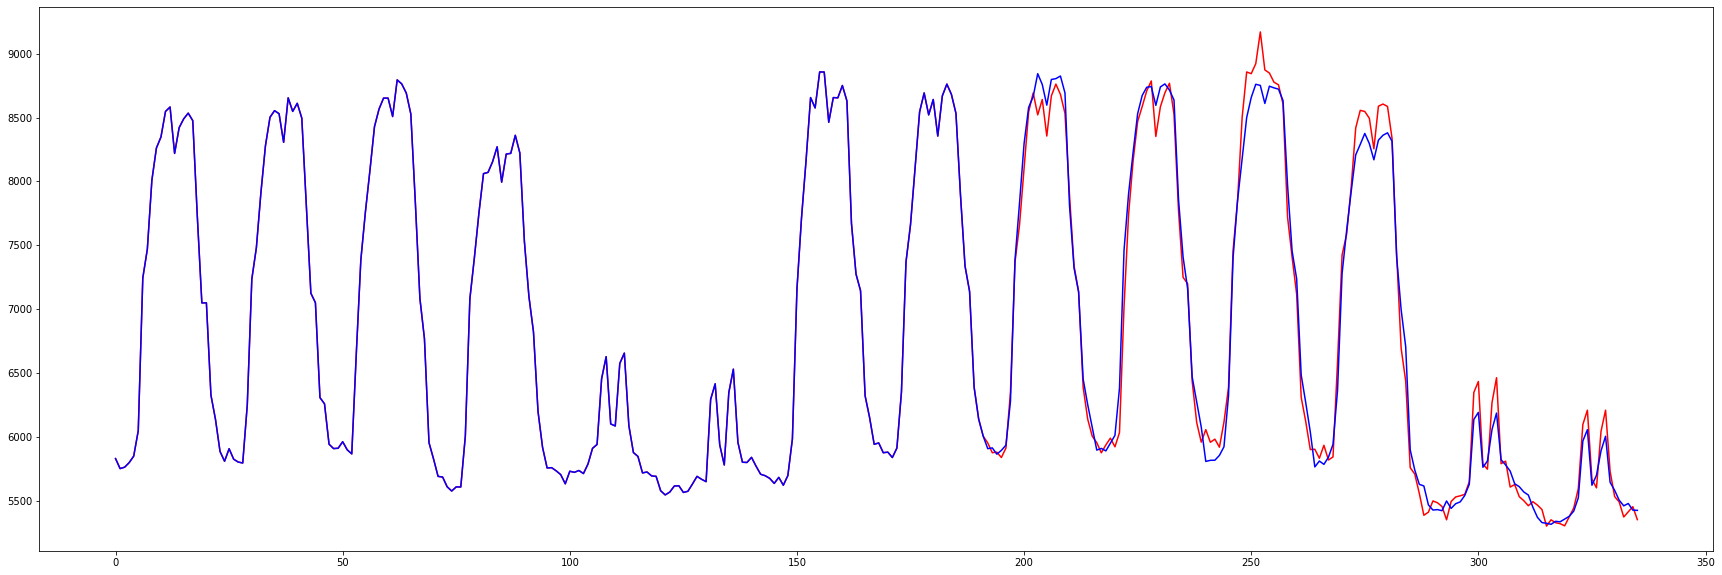

1.3732647252317907


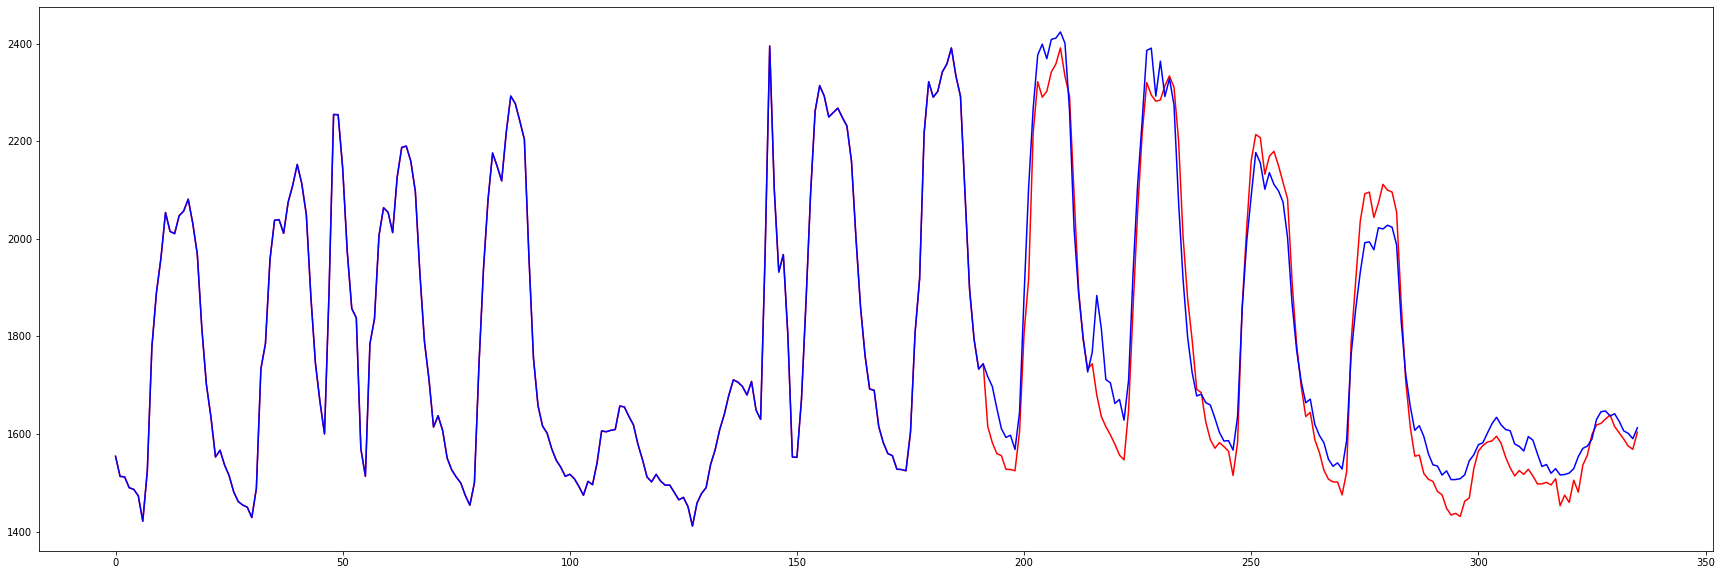

2.5554892878890234


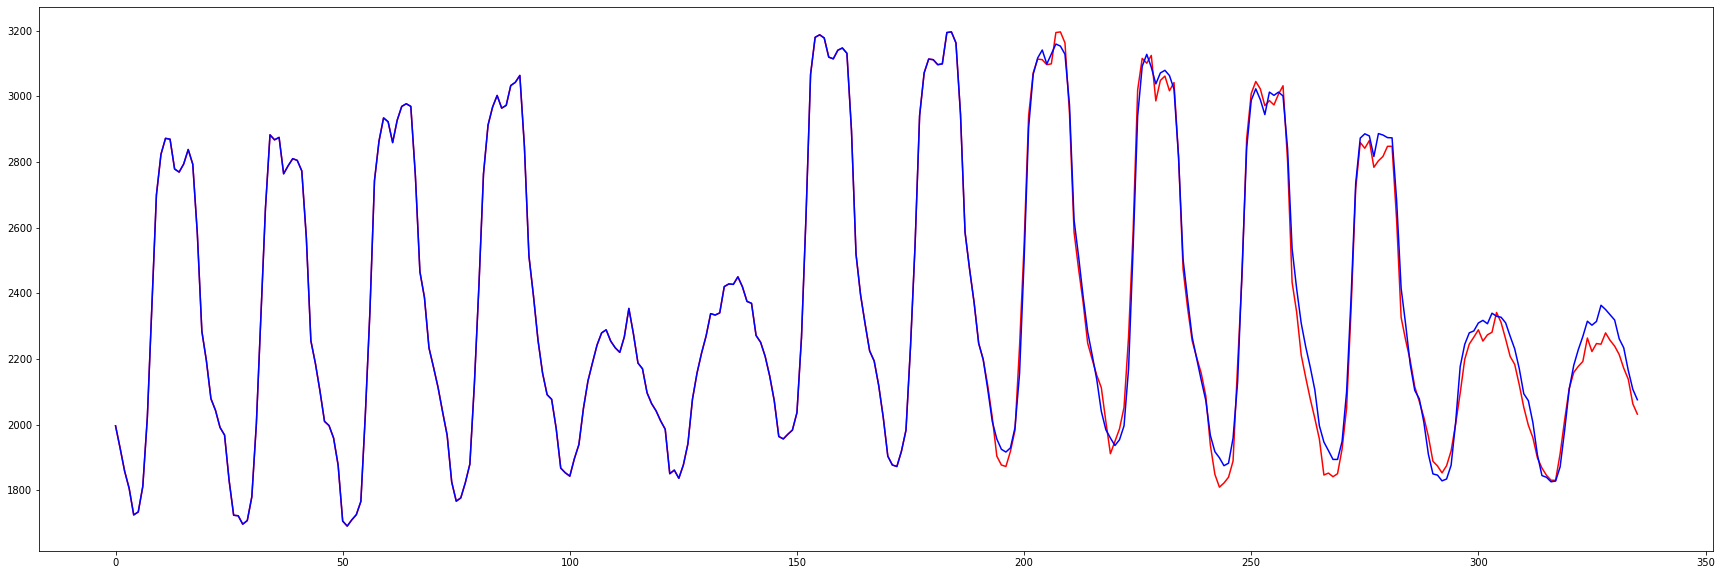

1.5196389595285995


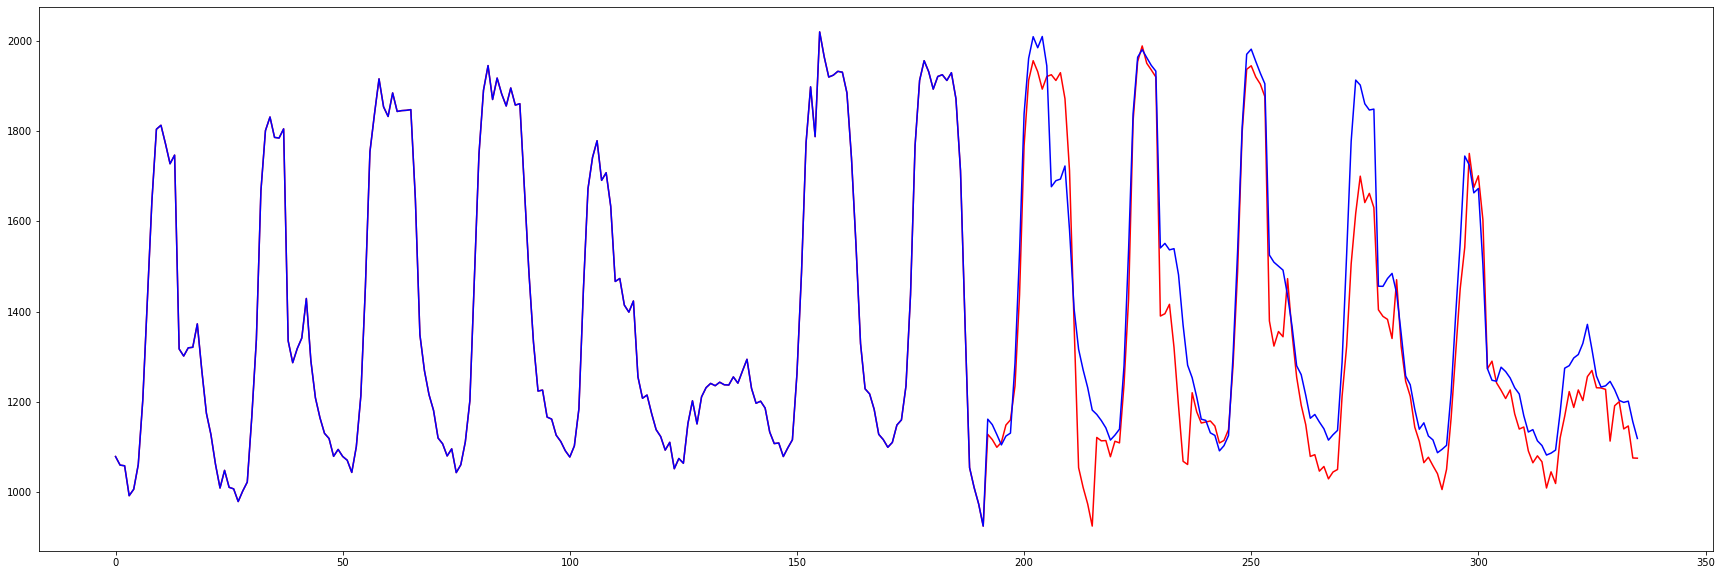

5.067647658559029


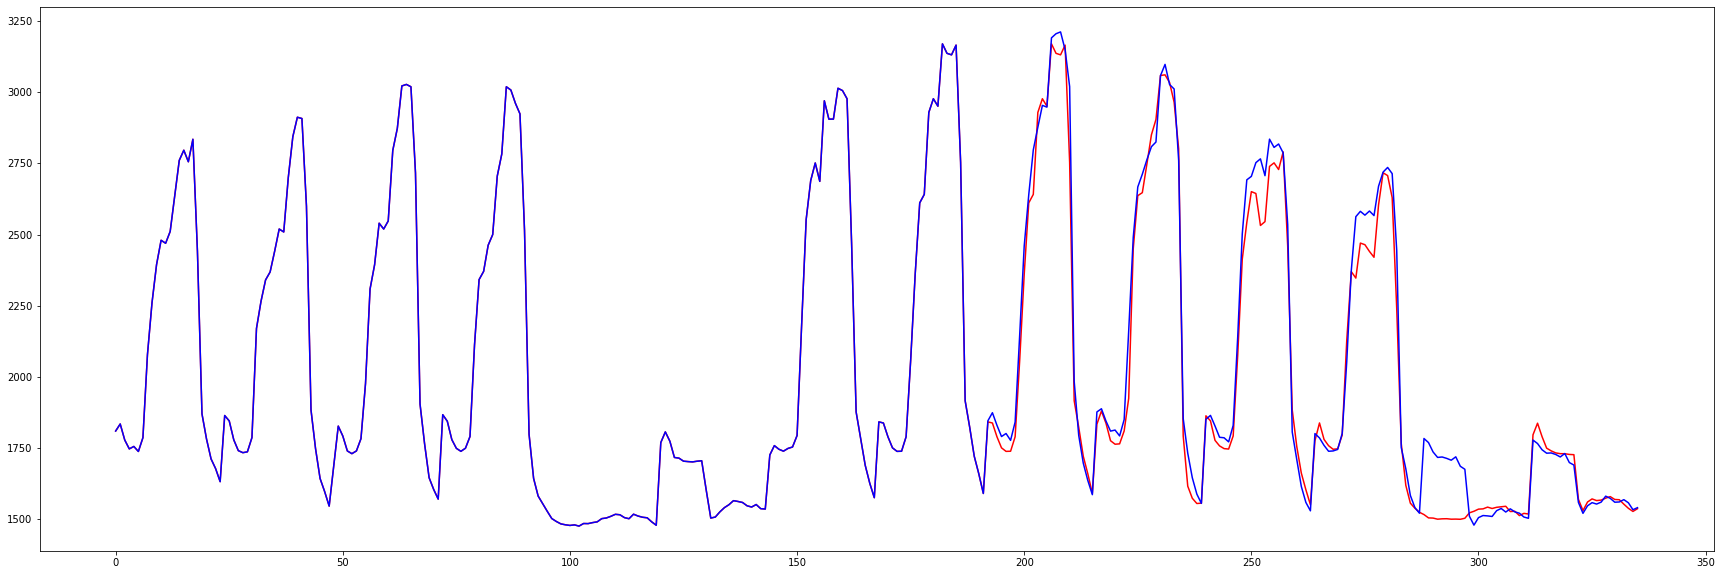

2.501093931201351


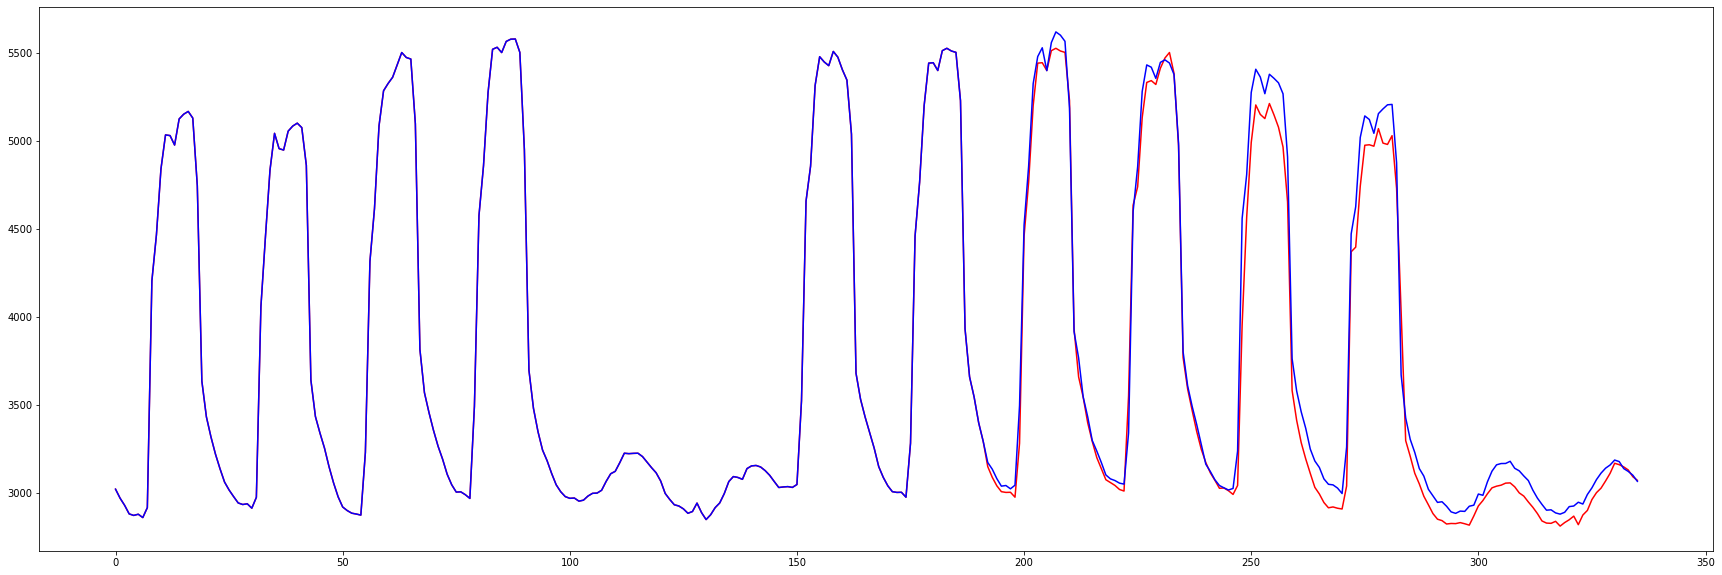

2.225887232957147


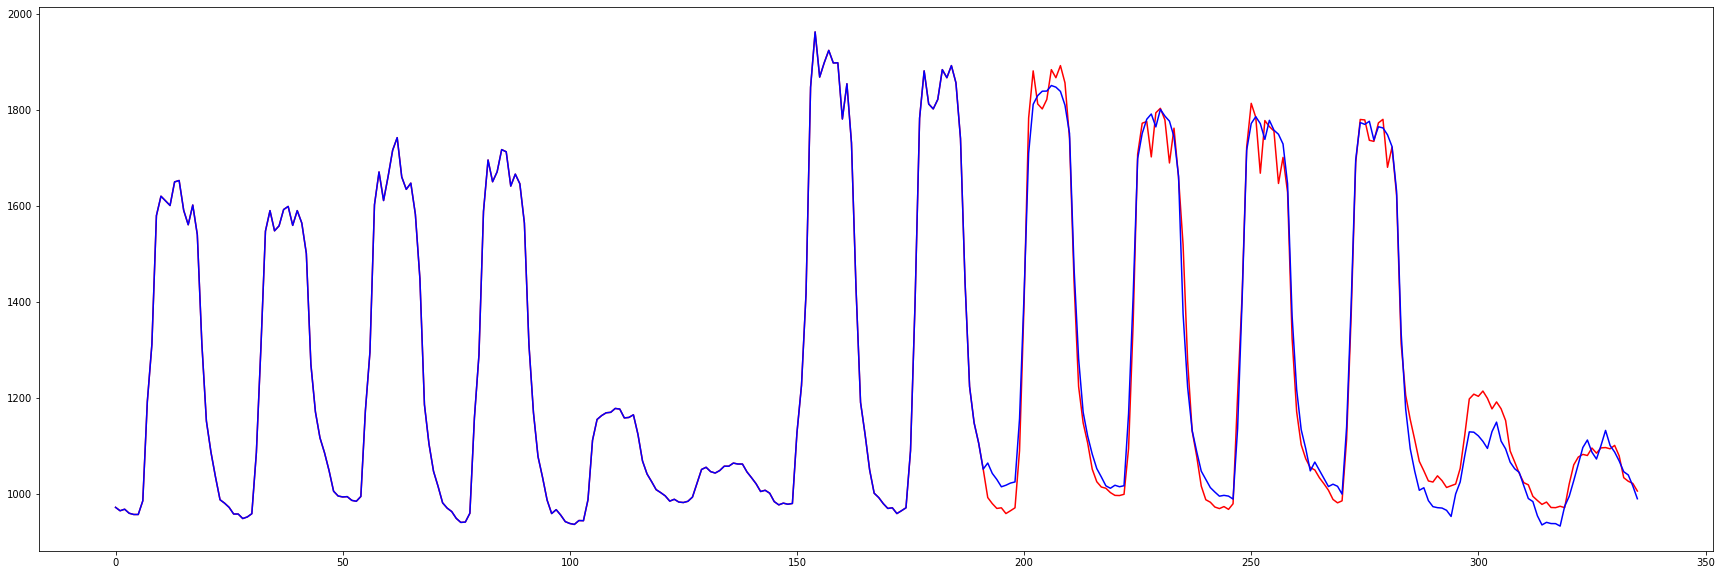

2.403910905969472


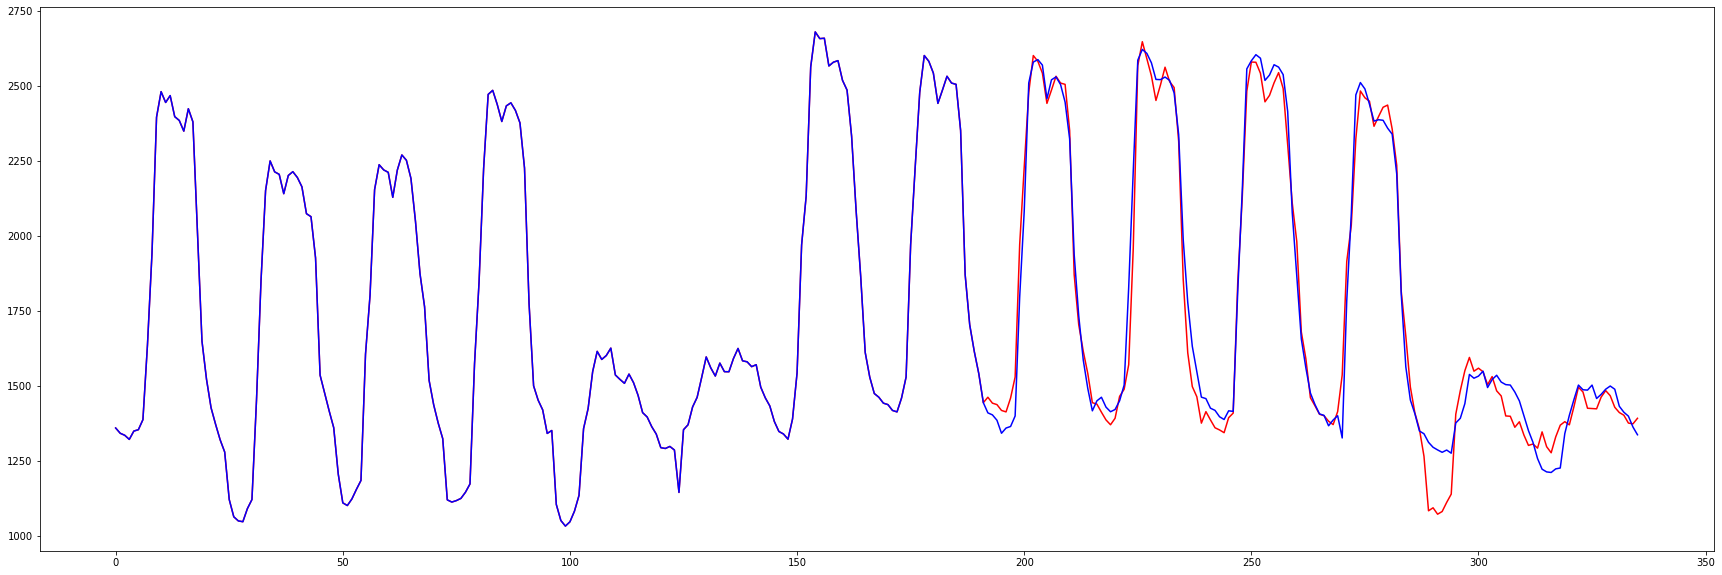

3.101997853883442


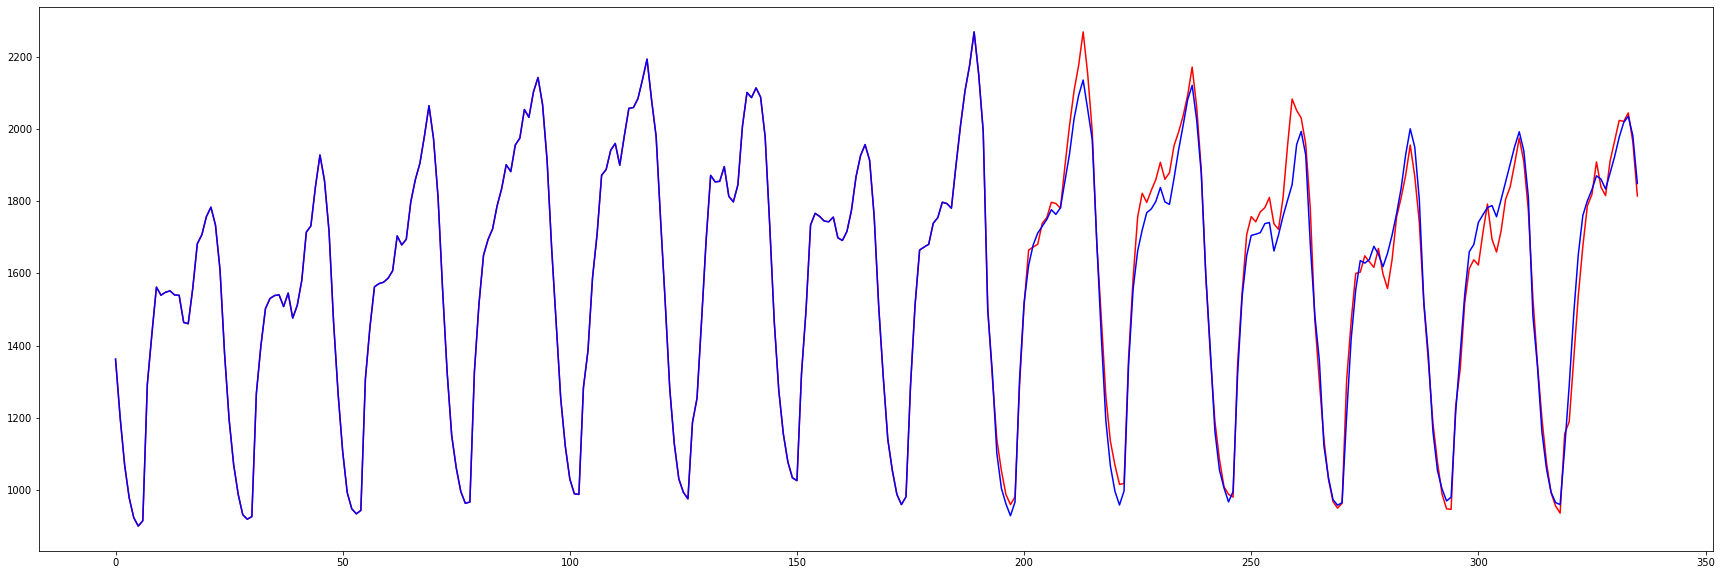

2.3033194915296233


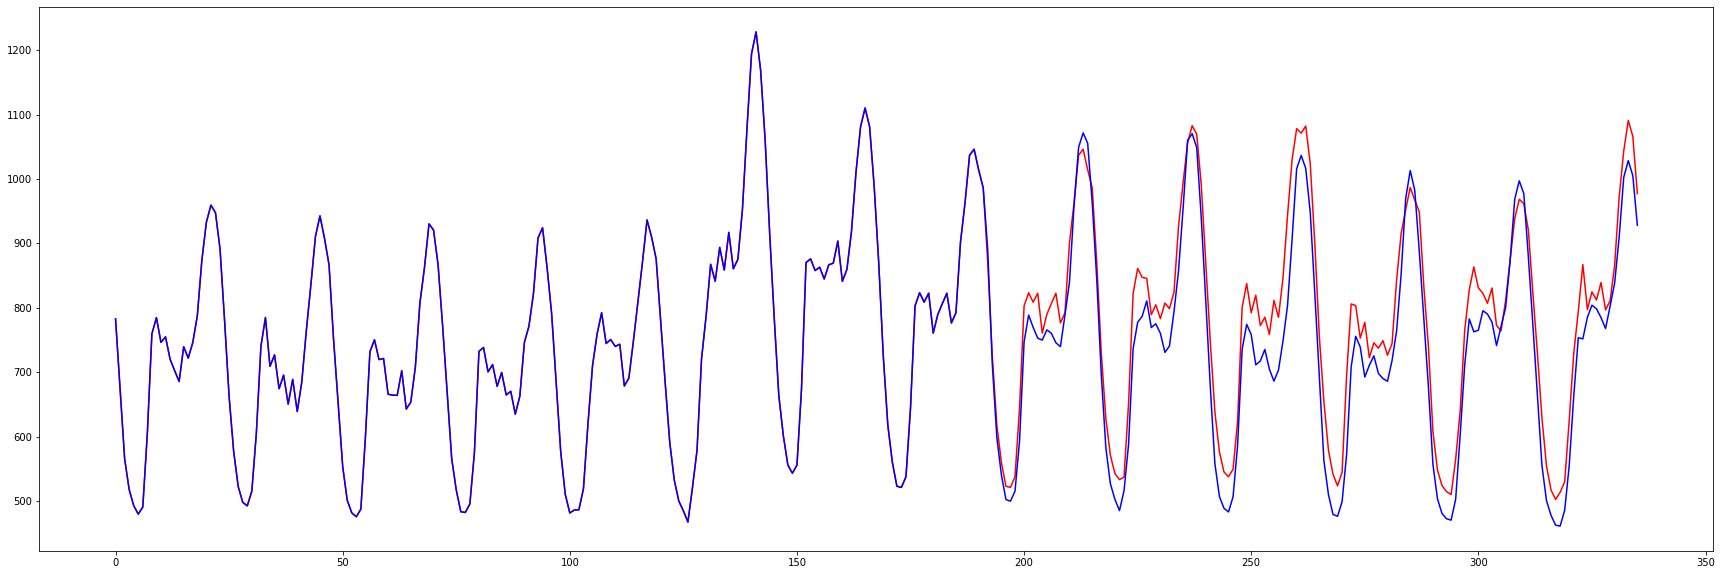

5.67034358138596


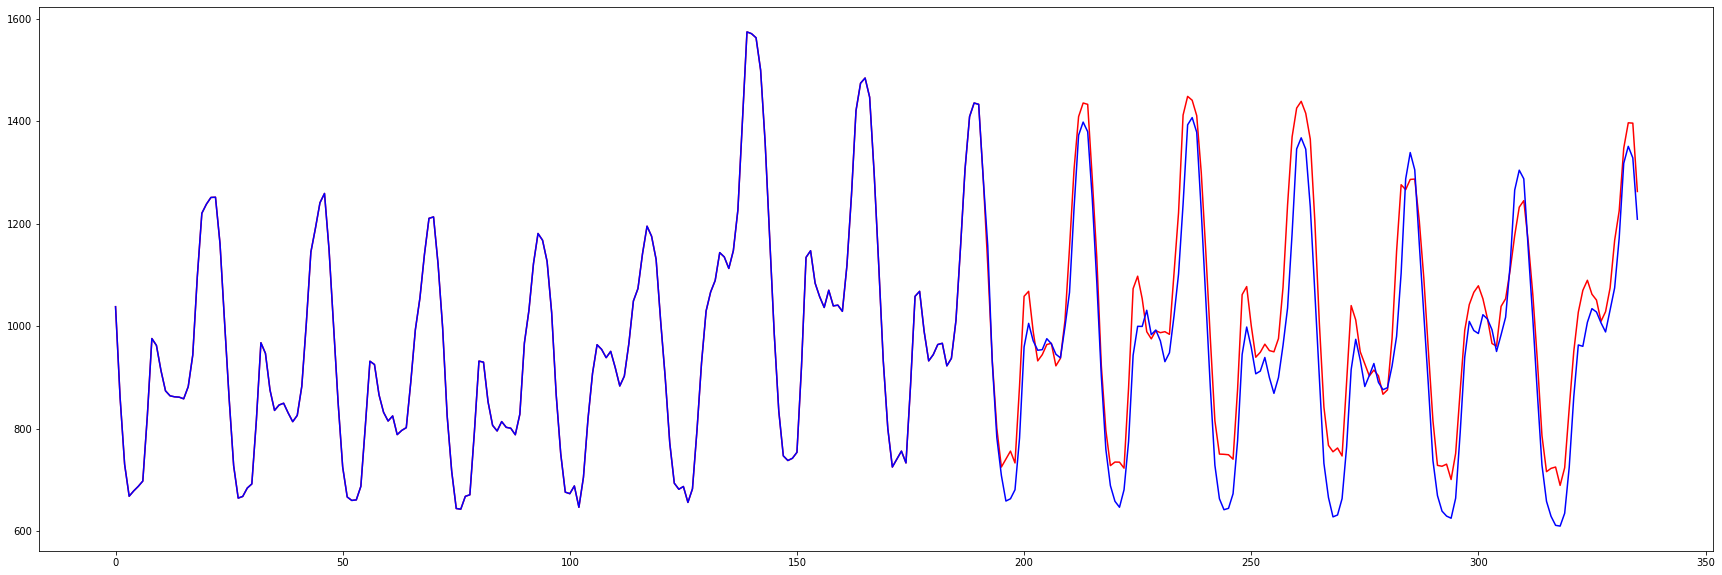

5.910612243348333


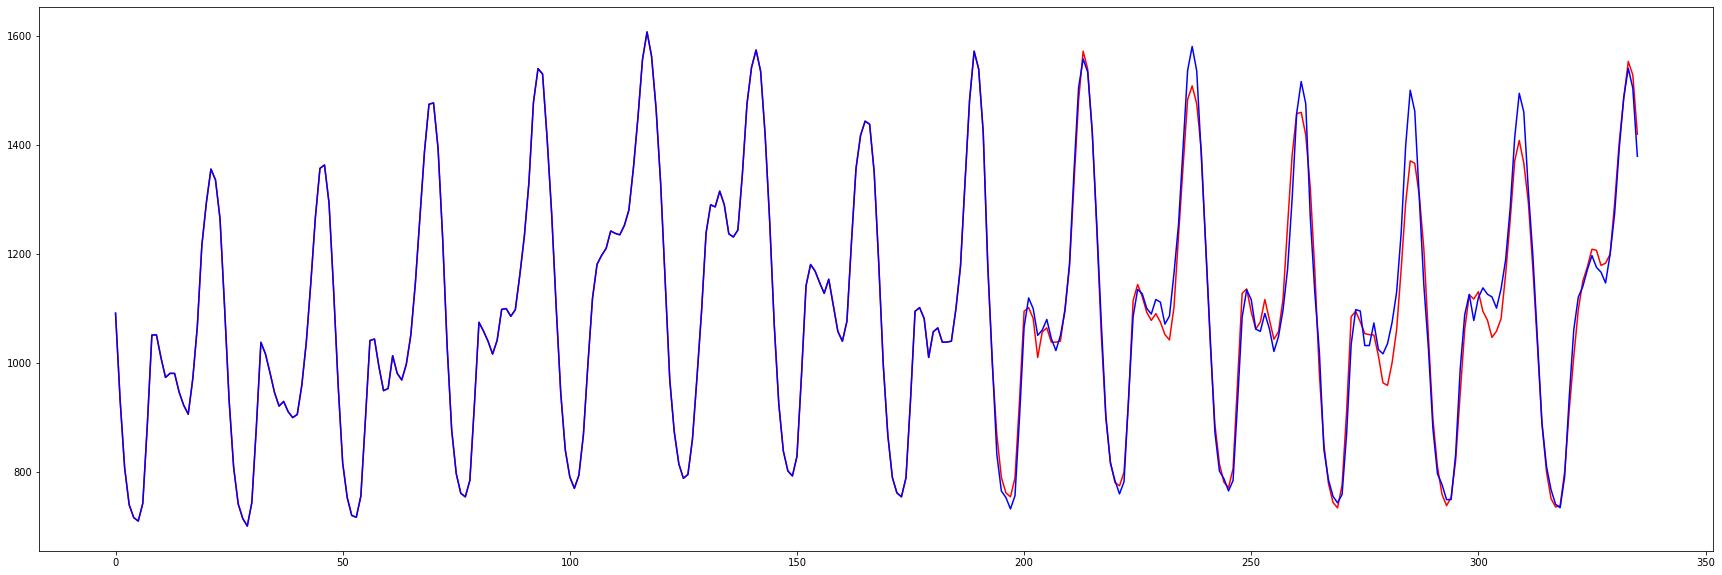

2.030030698288963


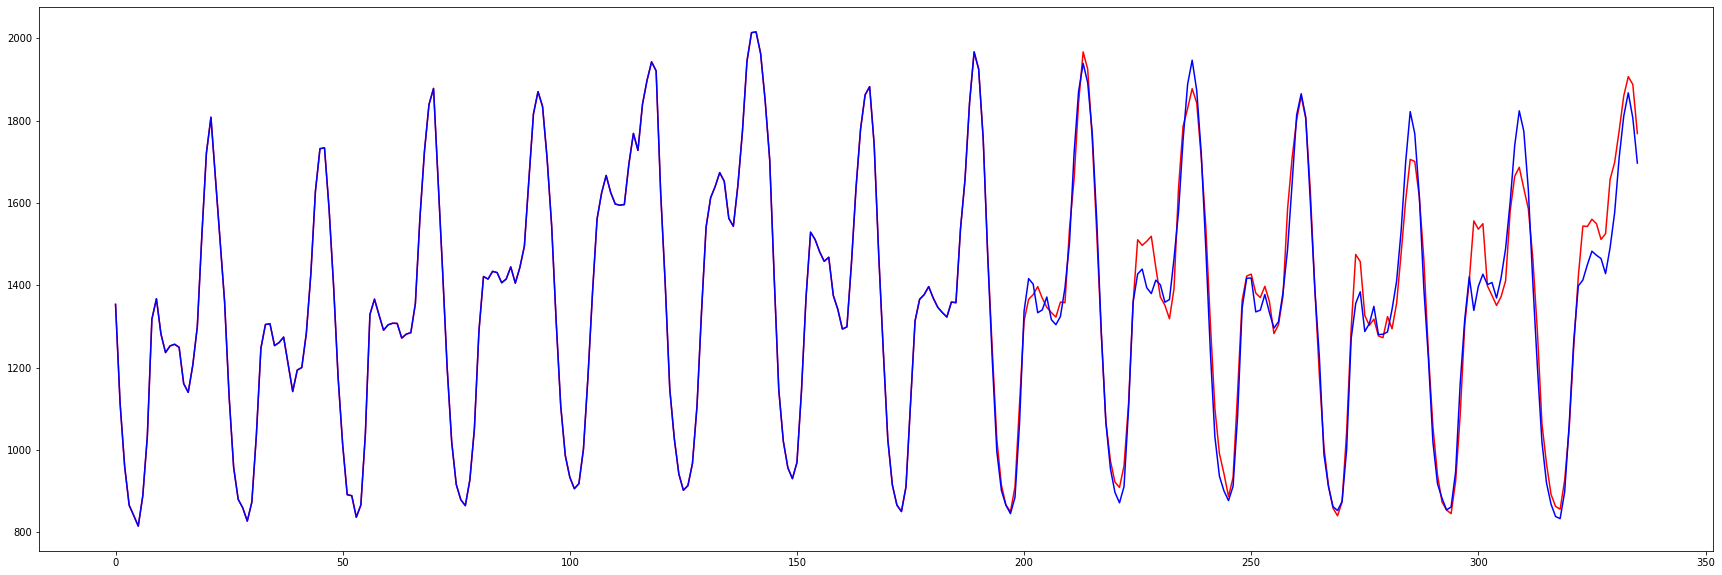

2.6680841155741897


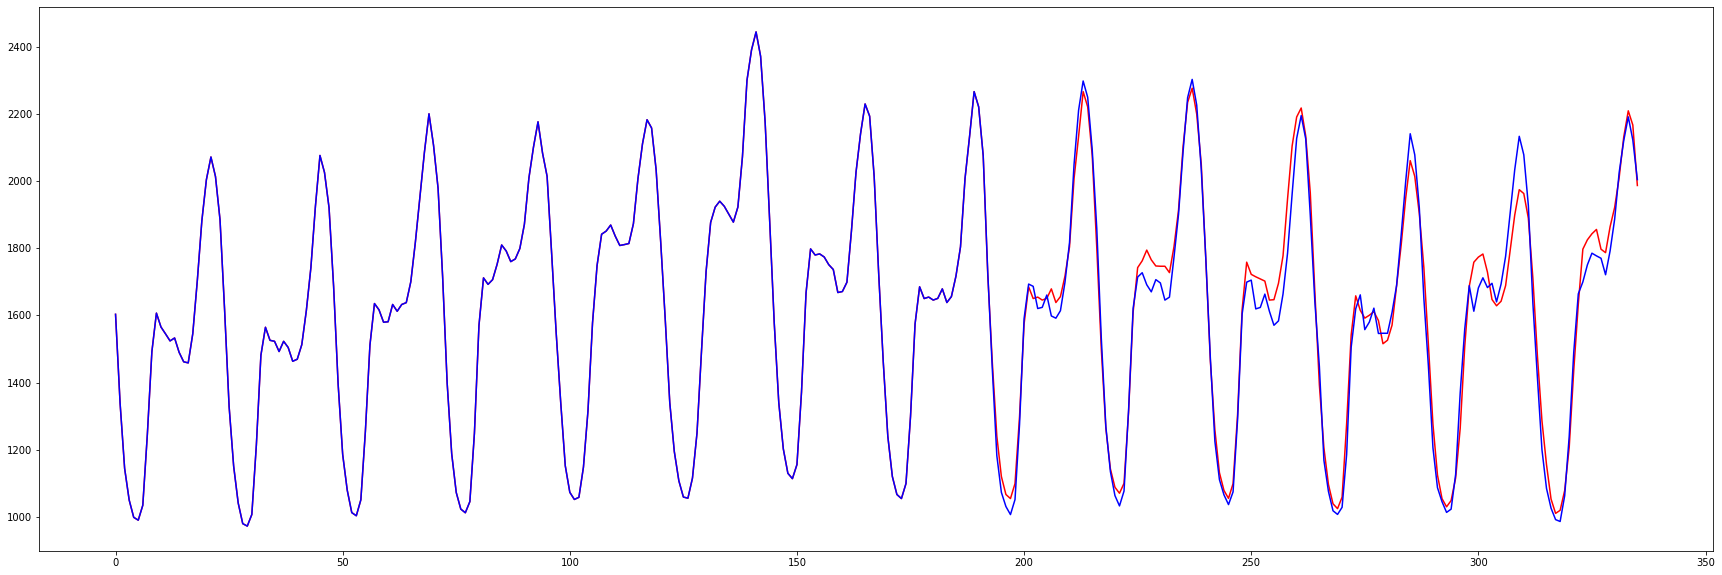

2.4272562661109696


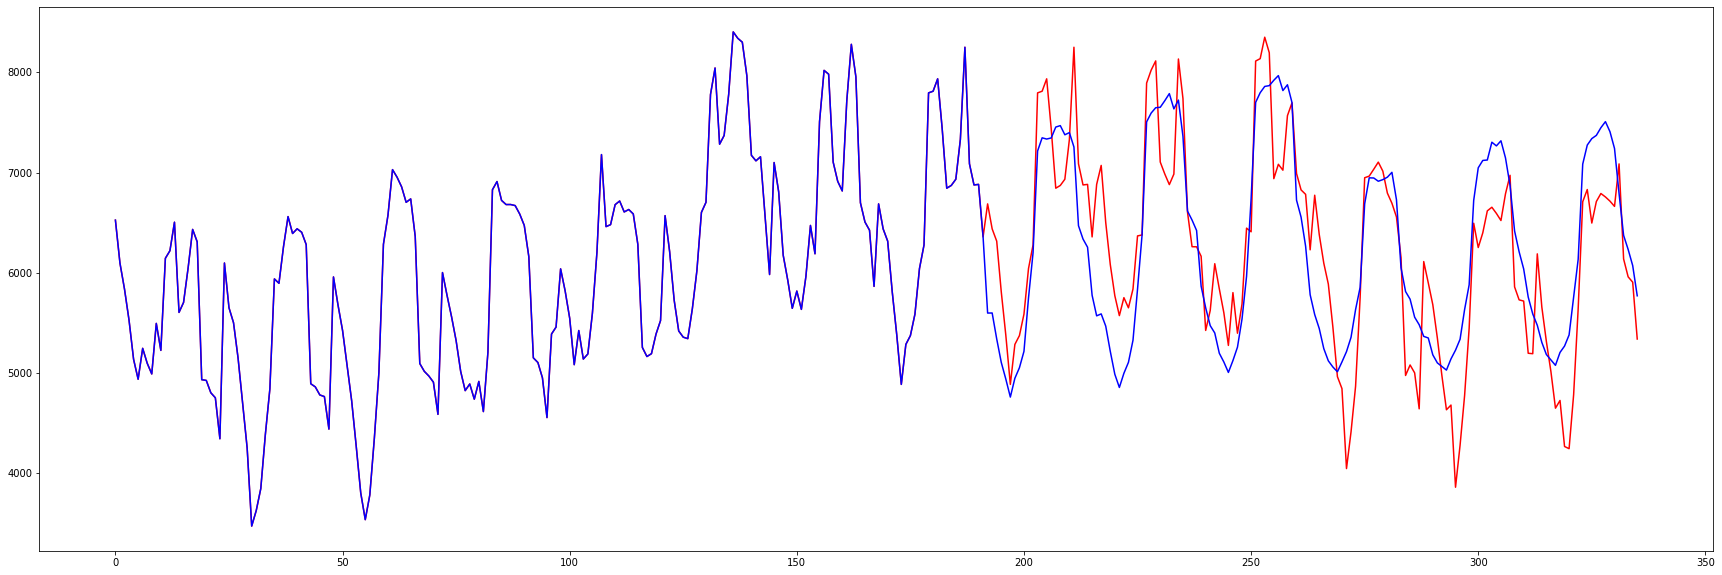

7.386993972239849


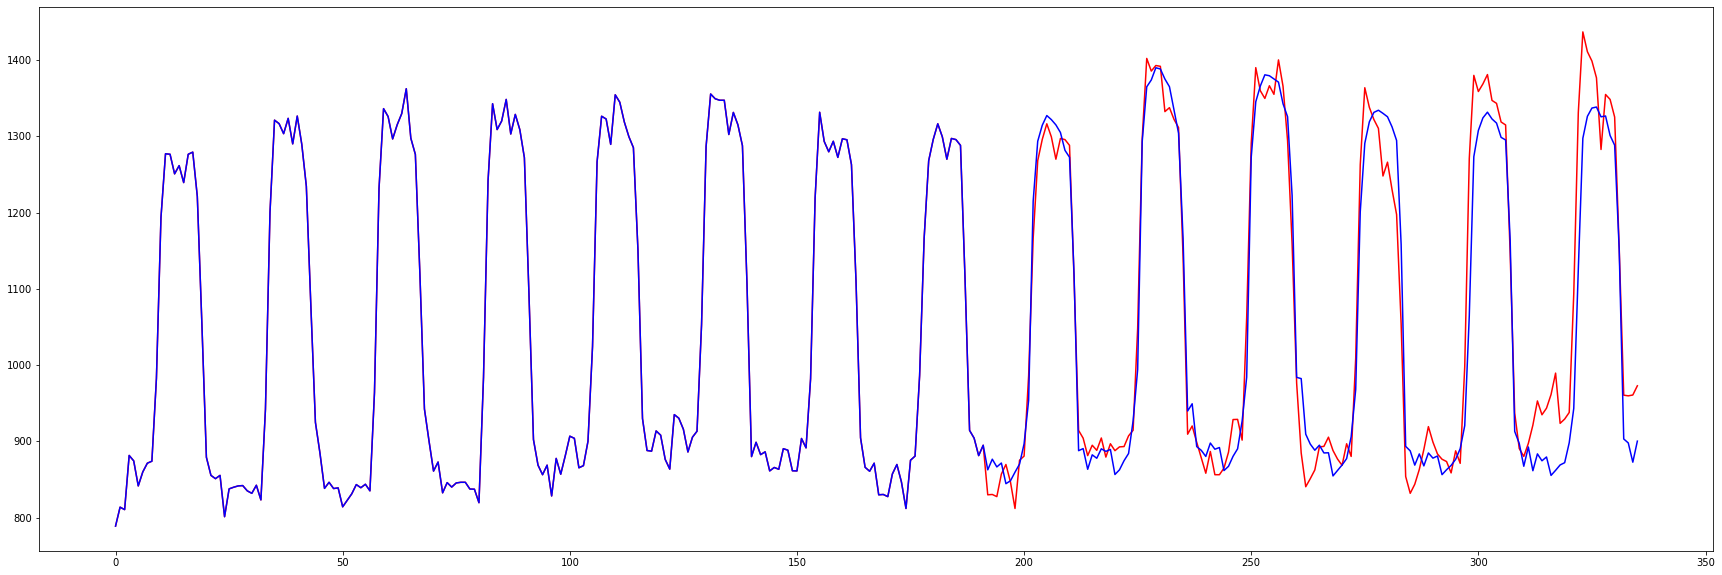

3.025761239750908


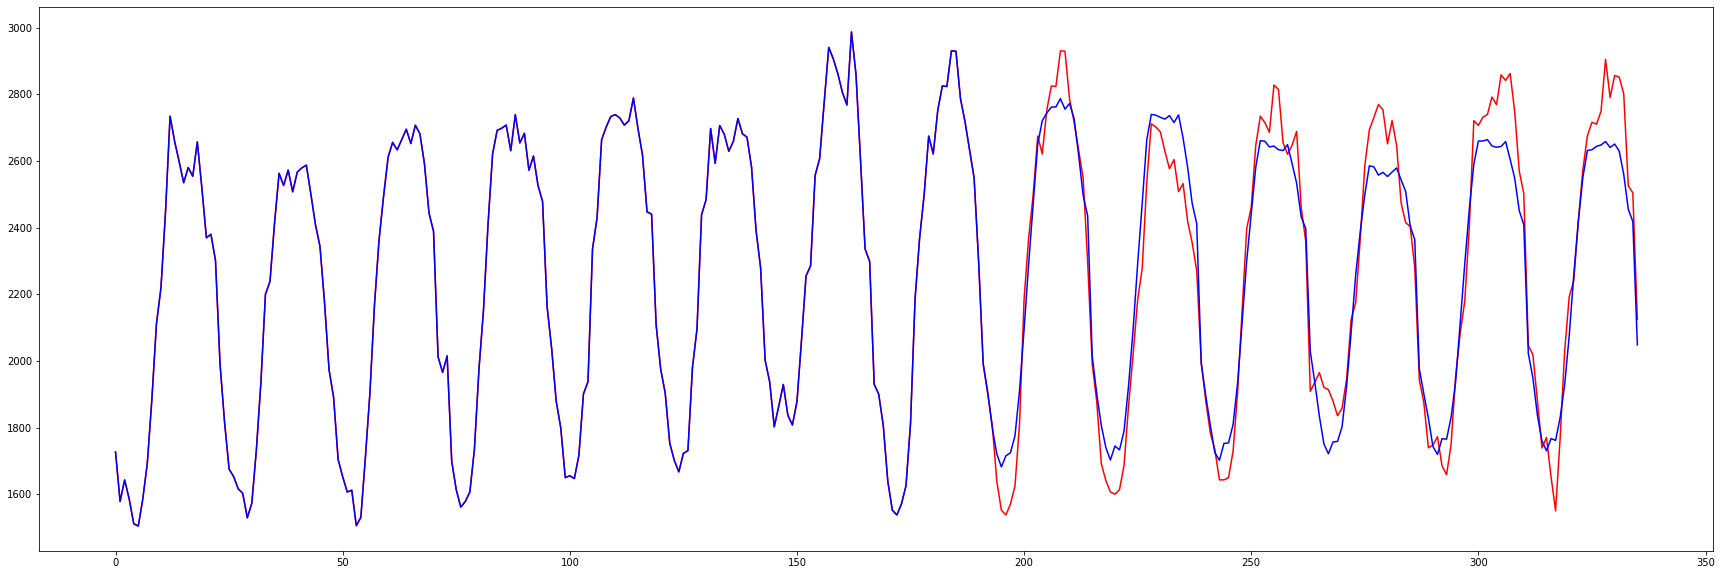

3.4421511931119277


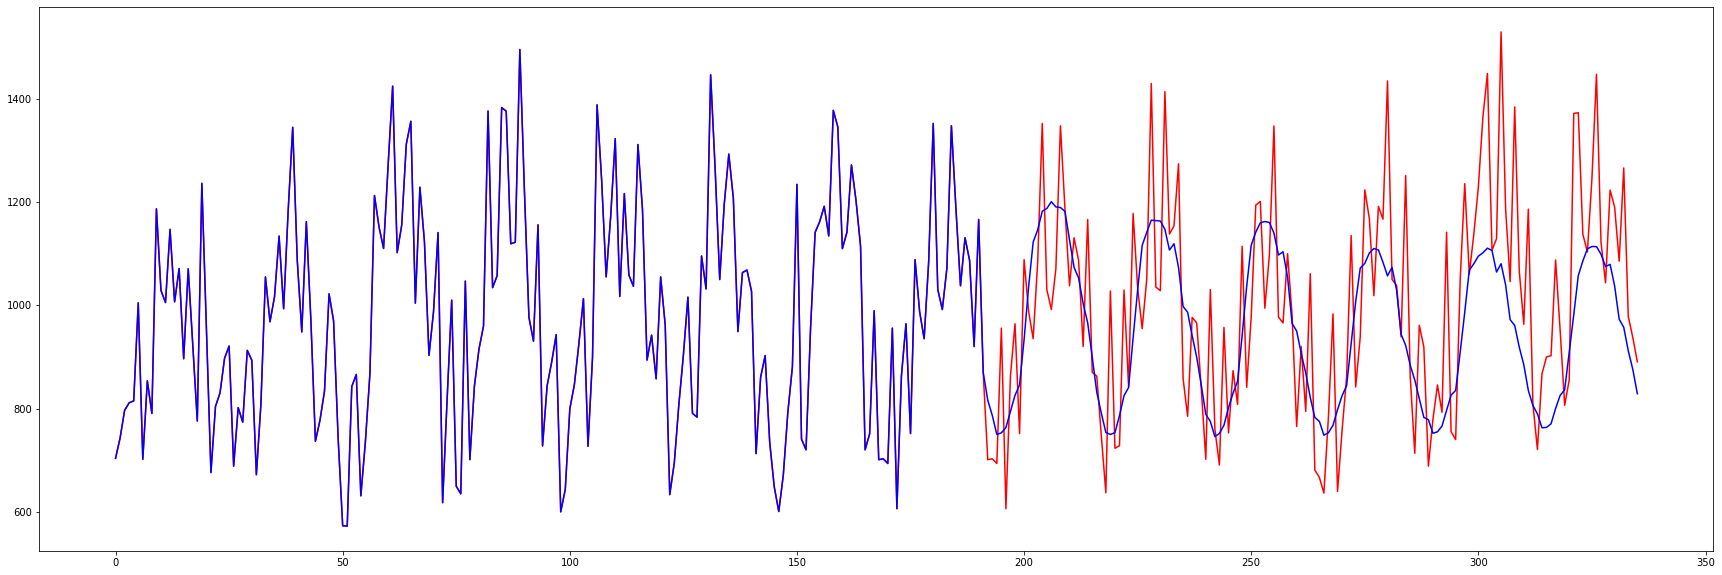

10.642973629108988


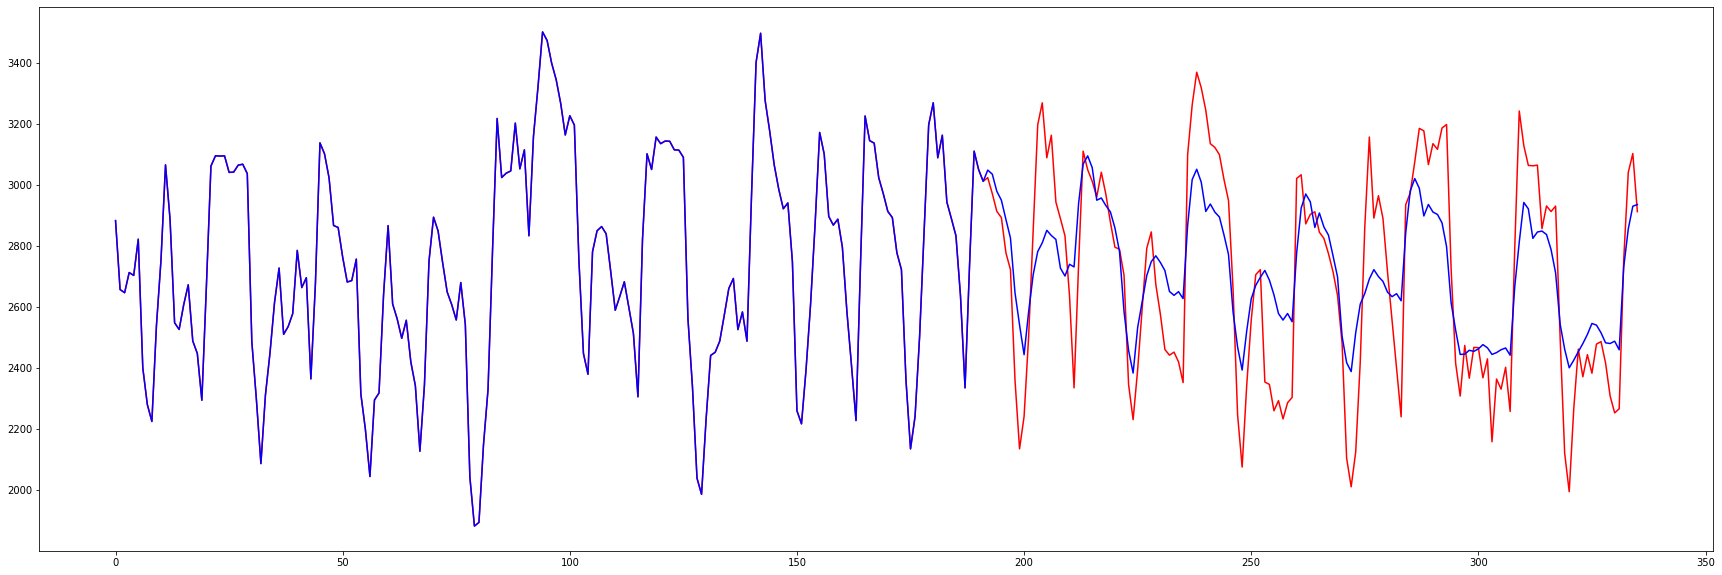

5.36201002193912


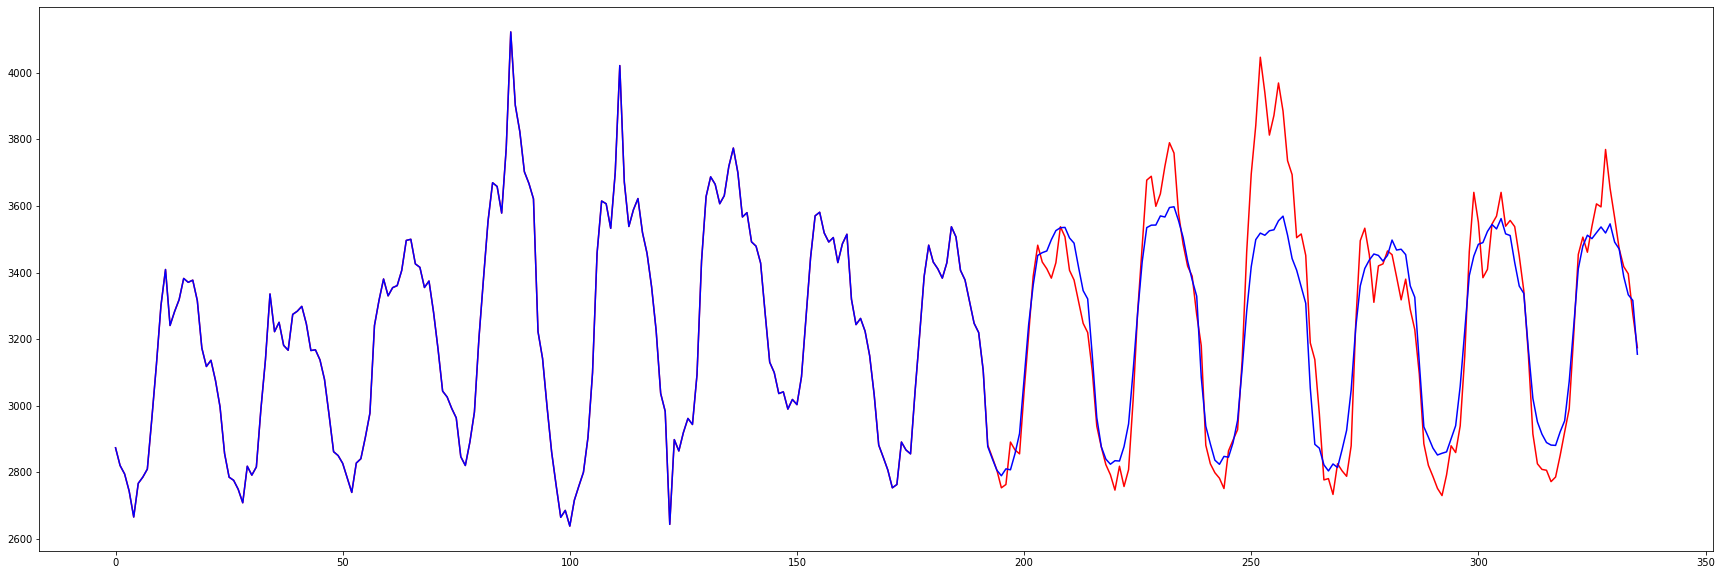

2.3081943061447294


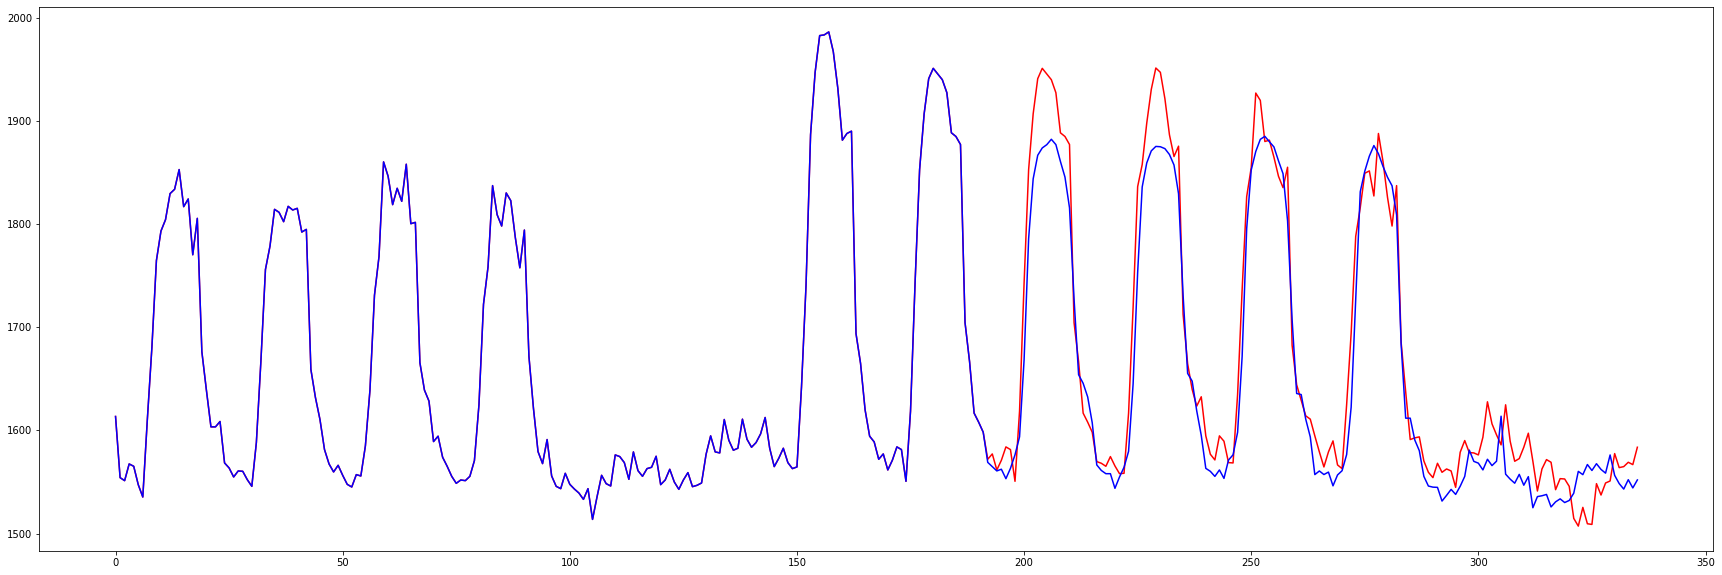

1.409604489252506


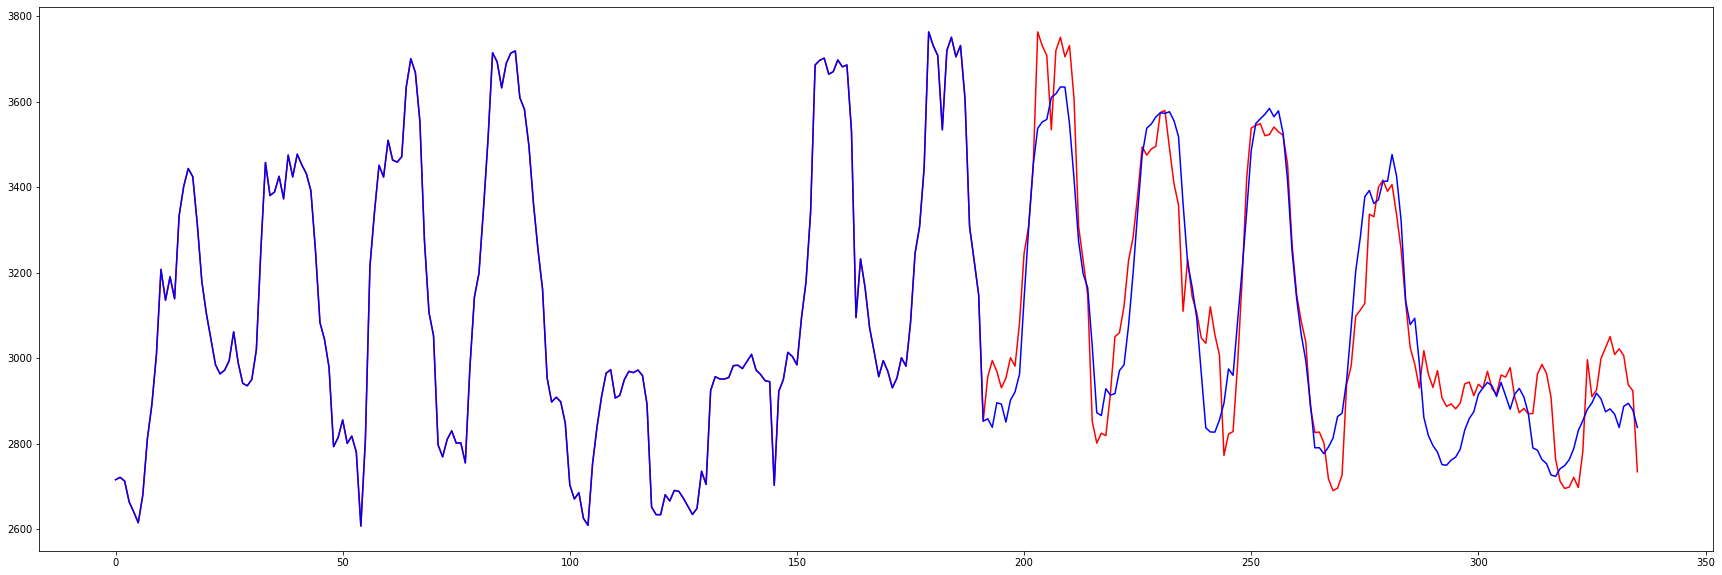

2.4020571986062063


selected time slice : 6
totoal score : 3.9502892238674234
A score : 8.060231362650683
B score : 3.5096583028582637
C score : 0.7843637064754431
D score : 3.4117157798003017
E score : 4.07067088902802


In [4]:
for i in range(len(model_paths)):
    now_dataframe = dataframes[i]
    now_dataframe['num'] = now_dataframe['num'].apply(str)
    now_dataframe['energy_group'] = now_dataframe['energy_group'].apply(str)
    now_dataframe['Week'] = now_dataframe['Week'].apply(str)
    now_dataframe['24Hour'] = now_dataframe['24Hour'].apply(str)
    now_dataframe['holiday'] = now_dataframe['holiday'].apply(str)
    now_dataframe['Weekend'] = now_dataframe['Weekend'].apply(str)
    
    now_best_tft = TemporalFusionTransformer.load_from_checkpoint(model_paths[i])

    for building in group[i]:
        now_building_dataframe = now_dataframe.loc[now_dataframe["num"] == str(building)].copy()
        now_building_dataframe = now_building_dataframe[start_point:start_point+input_length+duration]

        original = now_building_dataframe.iloc[0:input_length+output_length]["kWH"].tolist()
        prediction = now_building_dataframe.iloc[0:input_length+output_length]["kWH"].tolist()  

        total_cycle = (len(now_building_dataframe) - input_length - output_length) // output_length

        for k in range(total_cycle):
            now_start_point = k*output_length

            encoder_data = now_building_dataframe.iloc[now_start_point:now_start_point+input_length].copy()
            decoder_data = now_building_dataframe.iloc[now_start_point+input_length:now_start_point+input_length+output_length].copy()
            new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

            raw_predictions = now_best_tft.predict(new_prediction_data, mode="prediction").numpy().tolist()[0]
            originals = now_building_dataframe.iloc[now_start_point+input_length : now_start_point+input_length+output_length]["kWH"].tolist()

            prediction.extend(raw_predictions)
            original.extend(originals)

            # for next step, change dataframe's original value to predicted value
            for p in range(output_length):
                now_building_dataframe.iloc[now_start_point+input_length+p, now_building_dataframe.columns.get_loc("kWH")] = raw_predictions[p]
            
        if show_graph:
            plt.rcParams["figure.figsize"] = (30,10)
            fig = plt.figure()
            graph = fig.add_subplot(1, 1, 1)
            graph.plot(original, color='red')
            graph.plot(prediction, color='blue')
            plt.show()

        smape_loss = smape(np.array(prediction[168:]), np.array(original[168:]))
        print(smape_loss)
        all_smape.append(smape_loss)
        part_smape[i].append(smape_loss)

        # break
    # break

print("\n")
print(f"selected time slice : {random_choice}")
print(f"totoal score : {np.mean(np.array(all_smape))}")
print(f"A score : {np.mean(np.array(part_smape[0]))}")
print(f"B score : {np.mean(np.array(part_smape[1]))}")
print(f"C score : {np.mean(np.array(part_smape[2]))}")
print(f"D score : {np.mean(np.array(part_smape[3]))}")
print(f"E score : {np.mean(np.array(part_smape[4]))}")